In [629]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np 
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.stats import norm
from matplotlib import colors
plt.rcParams["font.family"] = "sans-serif"
from matplotlib.lines import Line2D


# Predicting gender pay gap from quartile data
The UK Gender Pay Gap data includes the following fields [gov.uk requirements](https://www.gov.uk/guidance/gender-pay-gap-reporting-make-your-calculations#gender-pay-gap-quartile-figures-you-must-calculate):
1. The classic gender pay gap variables being pay for women as a % of pay for men
* `DiffMeanHourlyPercent`
* `DiffMedianHourlyPercent`
2. The same but for bonus, with the percentage of men and women getting bonuses as an additional data point
* `DiffMeanBonusPercent`, `DiffMedianBonusPercent`, `MaleBonusPercent`, `FemaleBonusPercent`
3. The skew between genders by quartile (this is _what percentage of the employees are male or female_ in this quartile, for **full-pay employees**)
* `MaleLowerQuartile`,  `FemaleLowerQuartile`, `MaleLowerMiddleQuartile`, `FemaleLowerMiddleQuartile`, `MaleUpperMiddleQuartile`, `FemaleUpperMiddleQuartile`, `MaleTopQuartile`, `FemaleTopQuartile`

**What about the fact that people on Maternity Pay that aren't getting full pay are excluded from these figures?**

There is data for 2017, 2018 and partial data for 2019.


In [560]:
df1 = pd.read_csv('data/gender-pay-gap-uk-gov/2017.csv.gz',  compression='gzip')
df2 = pd.read_csv('data/gender-pay-gap-uk-gov/2018.csv.gz',  compression='gzip')
df3 = pd.read_csv('data/gender-pay-gap-uk-gov/2019.csv.gz',  compression='gzip')
YEARS = (2017, 2018, 2019)
df1['year'] = 2017
df2['year'] = 2018
df3['year'] = 2019
df = pd.concat([df1, df2, df3])
del df1, df2, df3
df['DiffMeanHourlyPercent'] = df['DiffMeanHourlyPercent'].astype(np.float32)
df['DiffMedianHourlyPercent'] = df['DiffMedianHourlyPercent'].astype(np.float32)
df['DiffMeanBonusPercent'] = df['DiffMeanBonusPercent'].astype(np.float32)
df['DiffMedianBonusPercent'] = df['DiffMedianBonusPercent'].astype(np.float32)
df['FemaleBonusPercent'] = df['FemaleBonusPercent'].astype(np.float32)
df['MaleBonusPercent'] = df['MaleBonusPercent'].astype(np.float32)

df =df.dropna(subset = {'DiffMeanHourlyPercent', 'DiffMedianHourlyPercent', 'DiffMeanBonusPercent','FemaleBonusPercent', 'MaleBonusPercent', 
                   'MaleLowerQuartile',  'FemaleLowerQuartile','MaleLowerMiddleQuartile', 'FemaleLowerMiddleQuartile', 'MaleUpperMiddleQuartile',
                    'FemaleUpperMiddleQuartile', 'MaleTopQuartile', 'FemaleTopQuartile' })
df= df.reset_index(drop=True)
df[['CurrentName', 'year', 'DiffMeanHourlyPercent', 'DiffMedianHourlyPercent', 'DiffMeanBonusPercent']].head(5)

CurrentName  year  DiffMeanHourlyPercent  \
0         BRYANSTON SCHOOL INCORPORATED  2017                   18.0   
1  "RED BAND" CHEMICAL COMPANY, LIMITED  2017                    2.3   
2                           118 LIMITED  2017                    1.7   
3                     123 EMPLOYEES LTD  2017                   41.0   
4                          1610 LIMITED  2017                  -22.0   

   DiffMedianHourlyPercent  DiffMeanBonusPercent  
0                28.200001              0.000000  
1                -2.700000             15.000000  
2                 2.800000             13.100000  
3                36.000000            -69.800003  
4               -34.000000            -47.000000

In [561]:
df['MalePerc'] = 0.25 * (df.MaleLowerQuartile + df.MaleLowerMiddleQuartile + df.MaleUpperMiddleQuartile + df.MaleTopQuartile)
df['FemalePerc']= 0.25 * (df.FemaleLowerQuartile + df.FemaleLowerMiddleQuartile + df.FemaleUpperMiddleQuartile +df.FemaleTopQuartile)
df['GenderSkew'] = df['MalePerc'] - df['FemalePerc']
df['GenderRatio'] = df['MalePerc'] / df['FemalePerc']
df['BonusGenderSkew'] = df['MaleBonusPercent'] - df['FemaleBonusPercent']

In [562]:
# Do more men than women get bonuses on average?
df2 = df[['CurrentName', 'year', 'DiffMeanHourlyPercent']]


# There are some anomalies in the data - like a company with a DiffMeanHourlyPercent of -500%!
# So we remove some outliers
df['DiffMeanHourlyPercent'].describe()

outliers_low = df["DiffMeanHourlyPercent"].quantile(0.01)
outliers_hi  = df["DiffMeanHourlyPercent"].quantile(0.99)

df_mean_hourly_filtered = df[(df["DiffMeanHourlyPercent"] < outliers_hi) & (df["DiffMeanHourlyPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMeanHourlyPercent']]


outliers_low = df["DiffMedianHourlyPercent"].quantile(0.01)
outliers_hi  = df["DiffMedianHourlyPercent"].quantile(0.99)

df_median_hourly_filtered = df[(df["DiffMedianHourlyPercent"] < outliers_hi) & (df["DiffMedianHourlyPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMedianHourlyPercent']]

outliers_low = df["DiffMeanBonusPercent"].quantile(0.01)
outliers_hi  = df["DiffMeanBonusPercent"].quantile(0.99)

df_bonus_filtered = df[(df["DiffMeanBonusPercent"] < outliers_hi) & (df["DiffMeanBonusPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMeanBonusPercent']]


outliers_low = df["DiffMedianBonusPercent"].quantile(0.01)
outliers_hi  = df["DiffMedianBonusPercent"].quantile(0.99)

df_mbonus_filtered = df[(df["DiffMedianBonusPercent"] < outliers_hi) & (df["DiffMedianBonusPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMedianBonusPercent']]


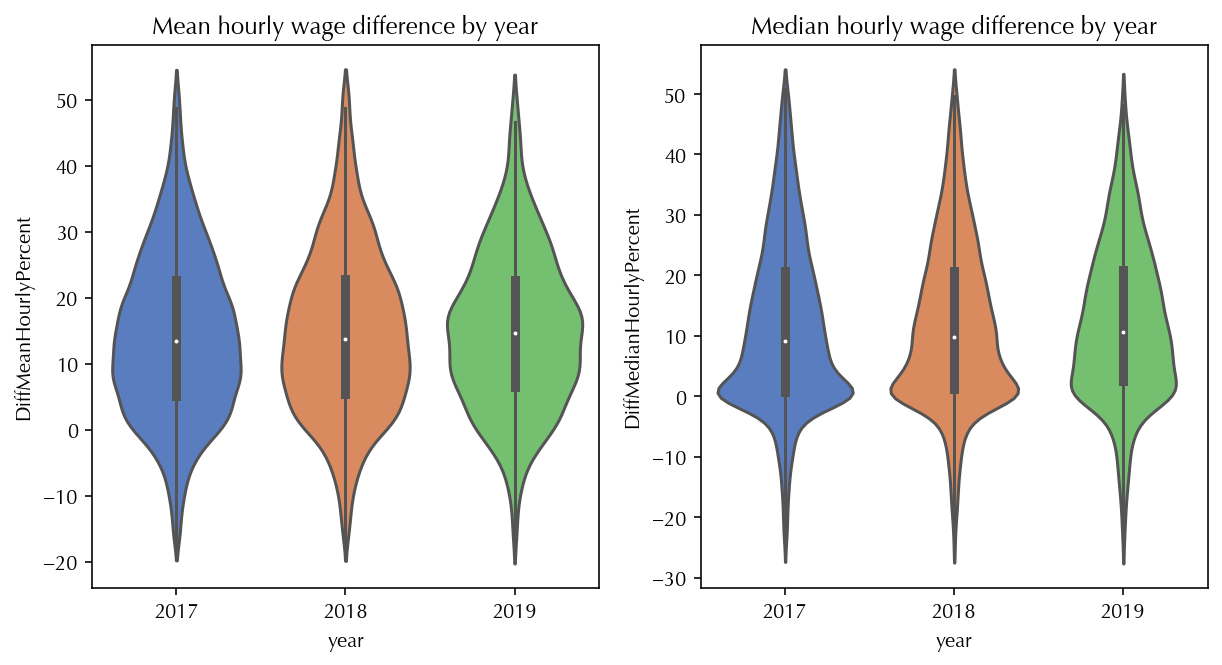

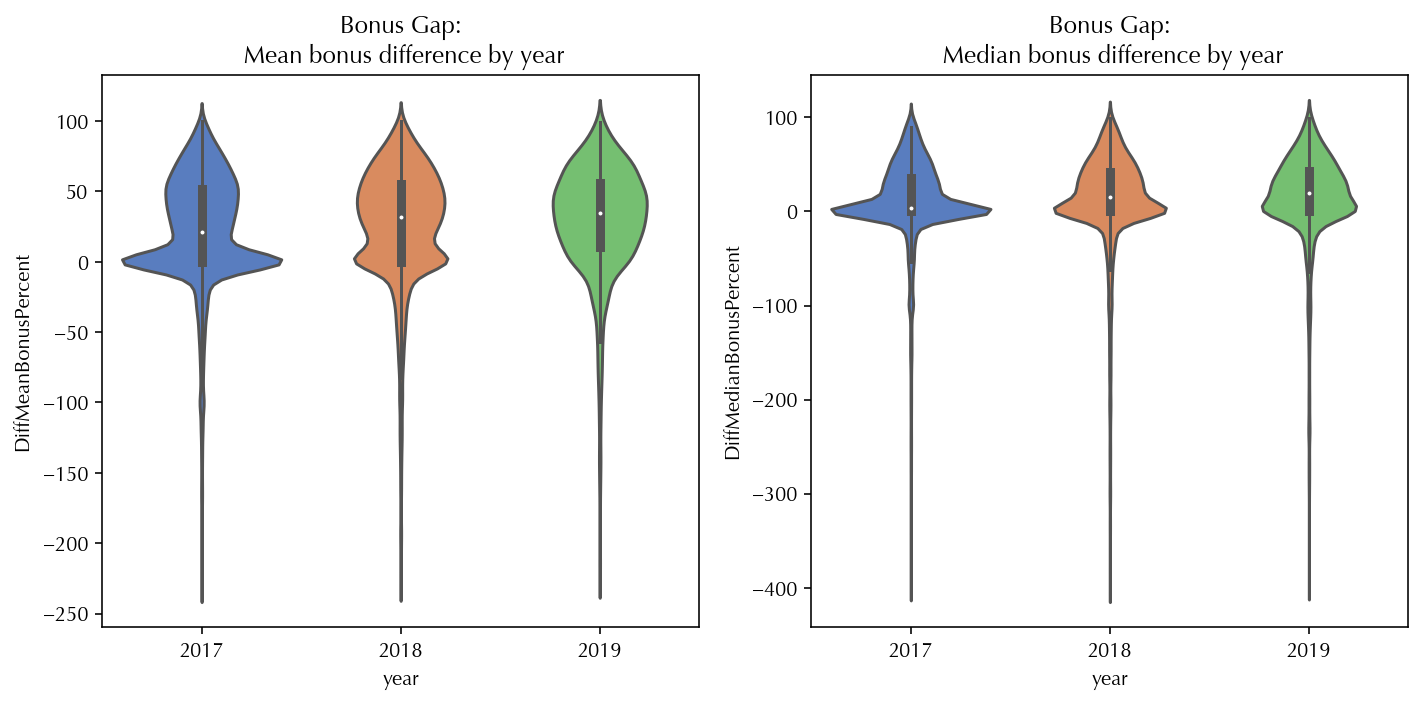

In [563]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.violinplot(ax=ax[0], y="DiffMeanHourlyPercent", x="year", 
                    data=df_mean_hourly_filtered, palette="muted", cut=True)
ax[0].set_title('Mean hourly wage difference by year')
sns.violinplot(ax=ax[1], y="DiffMedianHourlyPercent", x="year", 
                    data=df_median_hourly_filtered, palette="muted", cut=True)
ax[1].set_title('Median hourly wage difference by year')

fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.violinplot(ax=ax[0], y="DiffMeanBonusPercent", x="year", 
                    data=df_bonus_filtered, palette="muted")
ax[0].set_title('Bonus Gap:\n Mean bonus difference by year')
sns.violinplot(ax=ax[1], y="DiffMedianBonusPercent", x="year", 
                    data=df_mbonus_filtered, palette="muted")
ax[1].set_title('Bonus Gap:\n Median bonus difference by year')
plt.tight_layout()

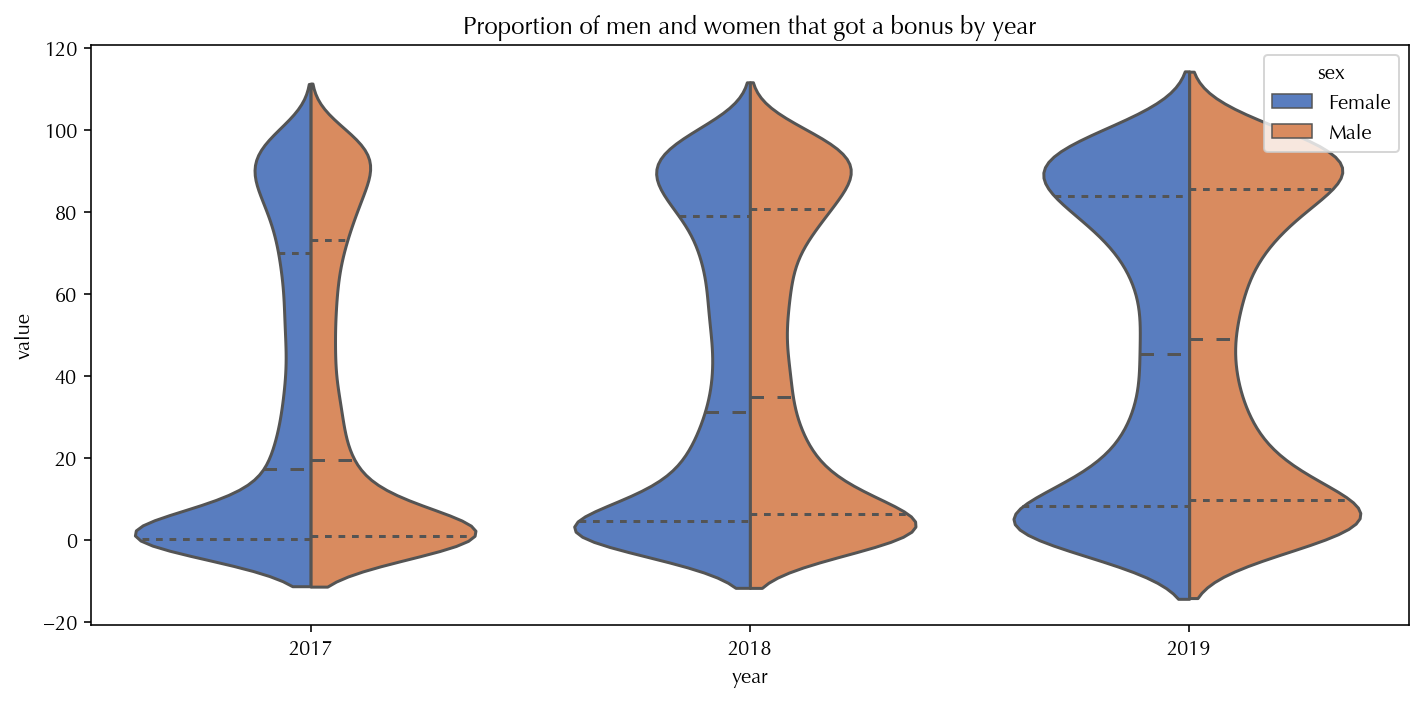

In [564]:
df2 = df[['CurrentName','year', 'FemaleBonusPercent', 'MaleBonusPercent']].melt(id_vars =['CurrentName', 'year'])
df2['sex'] = df2['variable'].map(lambda x: 'Male' if x == 'MaleBonusPercent' else 'Female')
del df2['variable']
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.violinplot(ax=ax, y="value", x="year", split=True, hue='sex', 
                     data=df2, palette="muted", inner='quartile')
ax.set_title('Proportion of men and women that got a bonus by year')

plt.tight_layout()

In [565]:
df2[['sex', 'value']].tail(100)

sex      value
45934  Male   2.300000
45935  Male  89.000000
45936  Male   1.600000
45937  Male   1.100000
45938  Male   5.600000
...     ...        ...
46029  Male  94.300003
46030  Male  11.700000
46031  Male  48.500000
46032  Male  49.799999
46033  Male  89.800003

[100 rows x 2 columns]

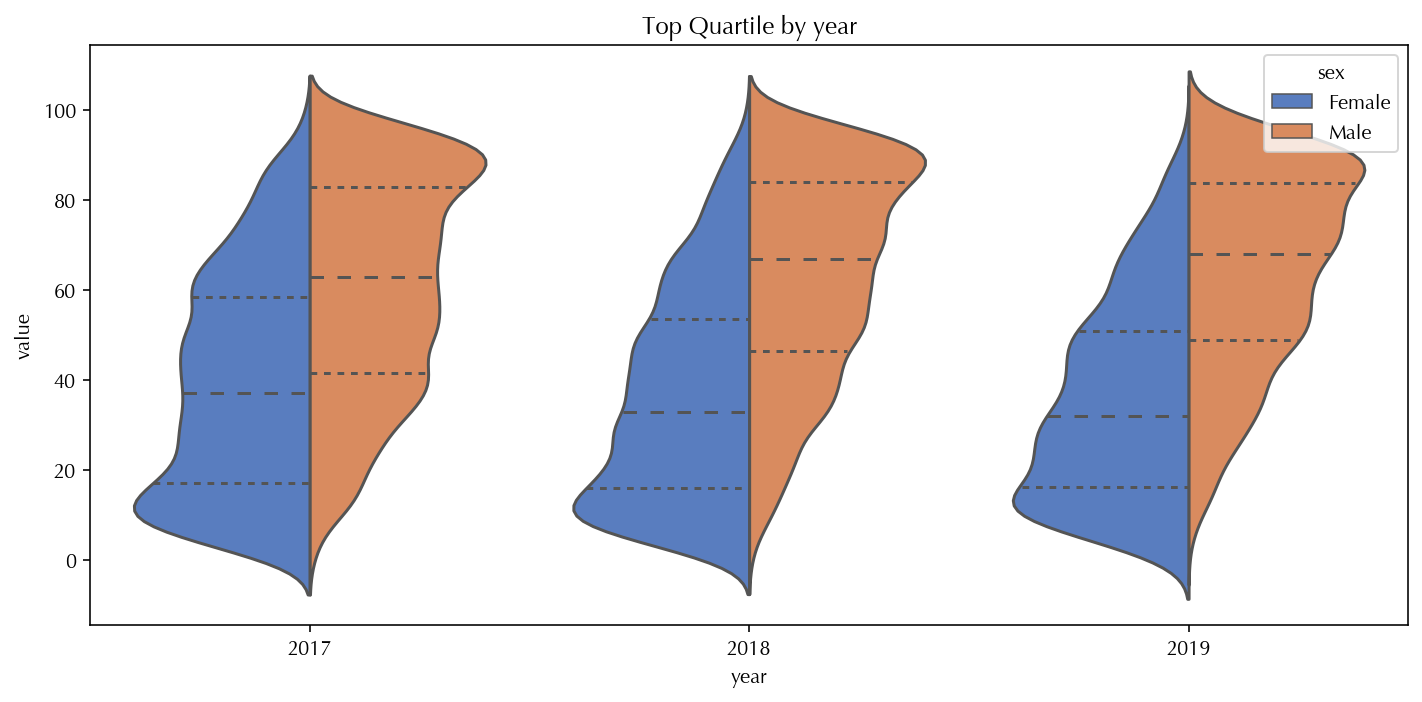

In [566]:
df2 = df[['CurrentName','year', 'FemaleTopQuartile', 'MaleTopQuartile']].melt(id_vars =['CurrentName', 'year'])
df2['sex'] = df2['variable'].map(lambda x: 'Male' if x == 'MaleTopQuartile' else 'Female')
del df2['variable']
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.violinplot(ax=ax, y="value", x="year", split=True, hue='sex', 
                     data=df2, palette="muted",inner='quartile')
ax.set_title('Top Quartile by year')
plt.tight_layout()

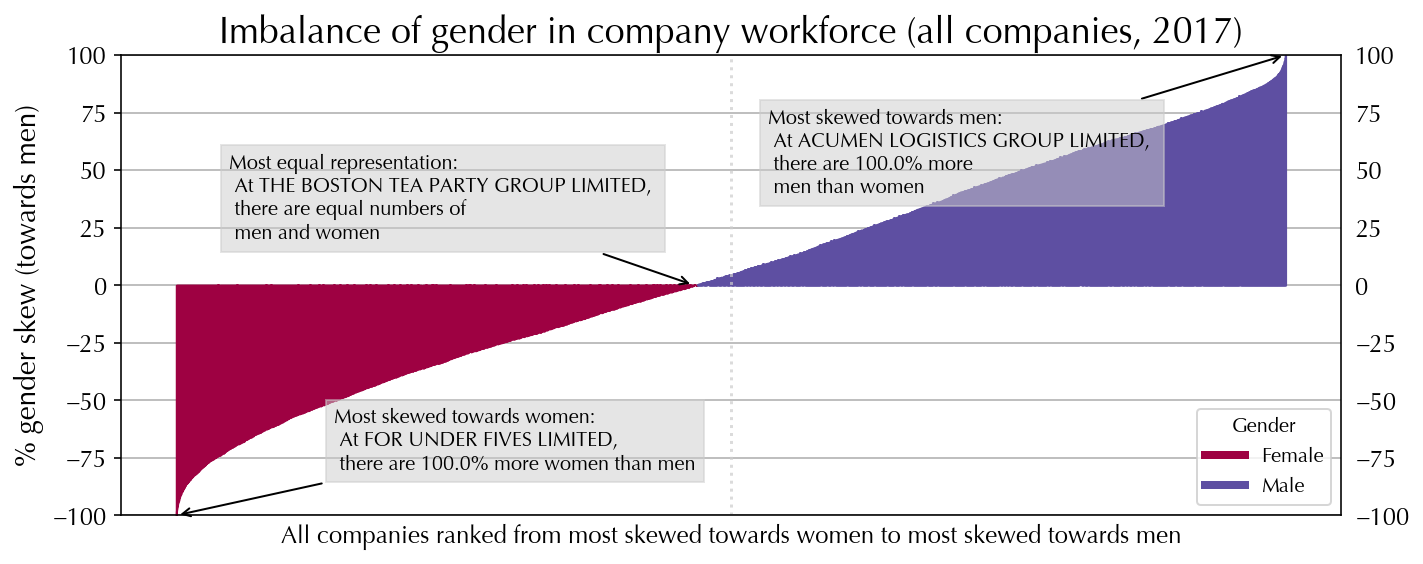

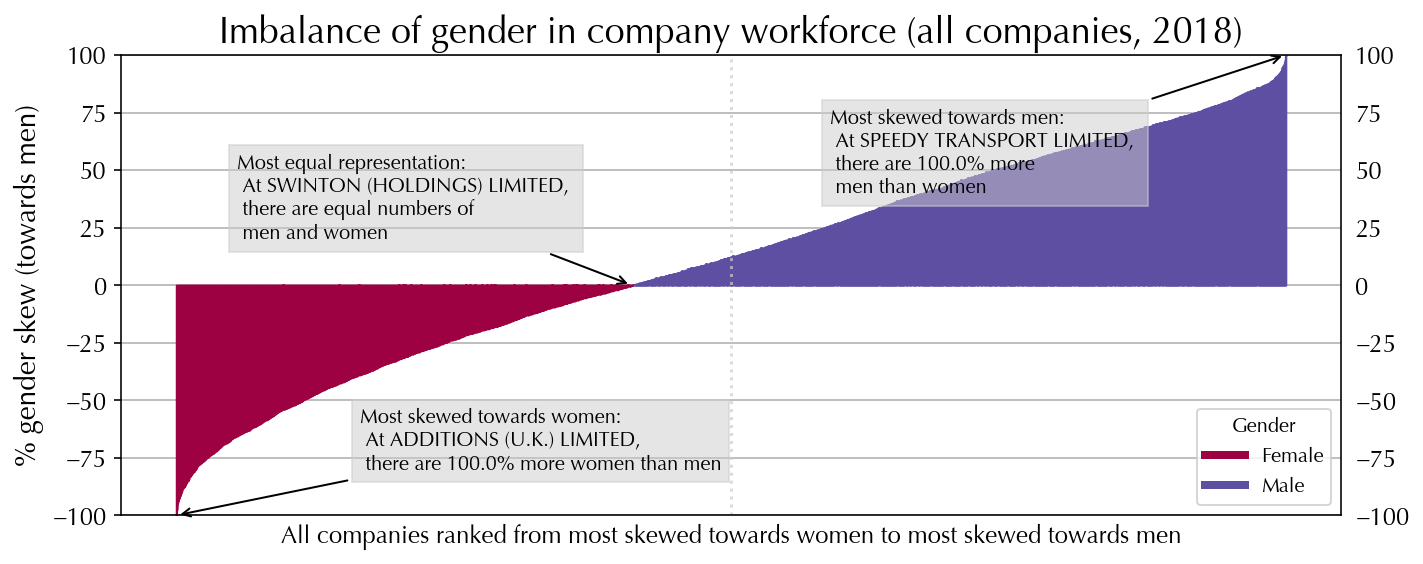

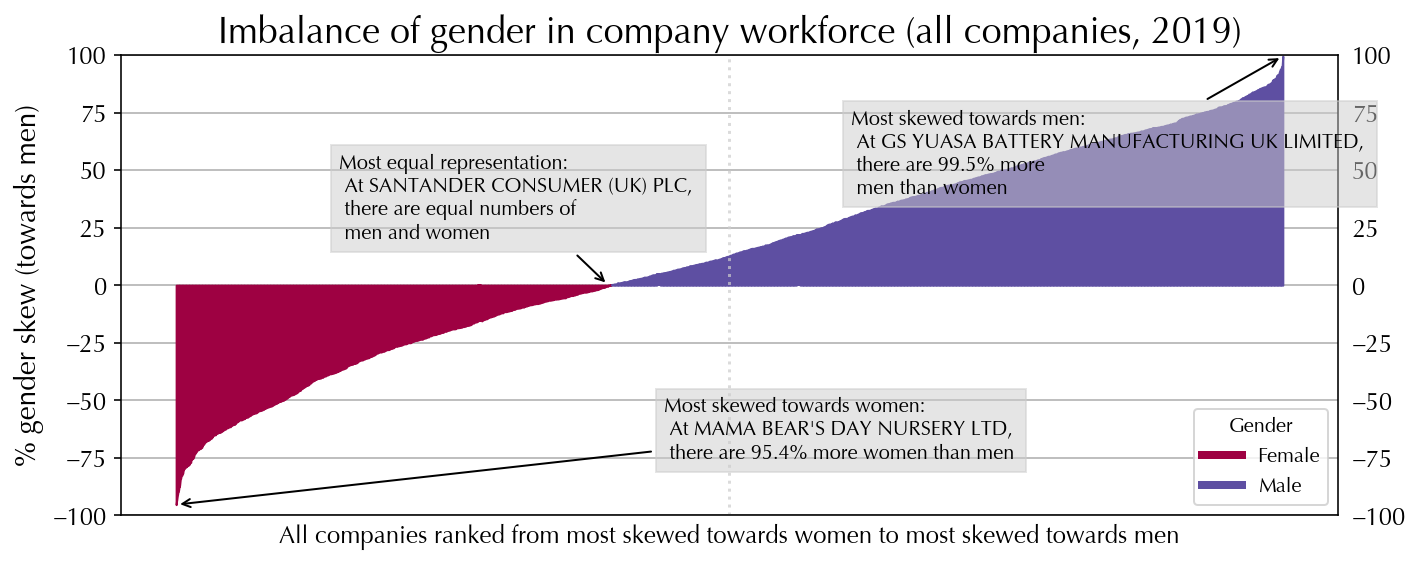

In [646]:
mpl.rcParams['font.family'] = 'Optima'
mpl.rcParams['text.usetex'] = 'False'

cmap = plt.cm.Spectral
STEP_SIZE=10
TRANSPARENT_GRAY=(0.8,0.8,0.8,0.7)
metric = 'GenderSkew'
sort_by ='GenderSkew'

for year in YEARS:
    fig, ax = plt.subplots(1,1,figsize=(10,4))
    fig.patch.set_visible(False)
    y = df[df['year'] == year].sort_values(sort_by)[metric].values
    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)
    normalize = colors.Normalize(vmin=min(y), vmax=max(y))

    fairest_idx = np.argmin(abs(y))
    fairest_company = df[df['year'] == year].sort_values(sort_by)['CurrentName'].values[fairest_idx]
    most_women_company = df.loc[df[df['year'] == year][metric].idxmin()]['CurrentName']
    most_women_skew_perc =  -y[0]
    most_men_company = df.loc[df[df['year'] == year][metric].idxmax()]['CurrentName']
    most_men_skew_perc = y[-1]

    # Draw bars for each of the companies
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        color = cmap(-1. if y[i] <0 else 1. if y[i] > 0 else 0)
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=color)

    ax.set_title('Imbalance of gender in company workforce (all companies, {})'.format(year),
                **{ 'fontsize': 18})    

    ax.annotate(xytext=(1500, y[0]+ 20),
                s='Most skewed towards women: \n At {}, \n there are {:.1f}% more women than men'
                    .format(most_women_company, most_women_skew_perc),
                xy = (x[0], y[0]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(x[-1]-fairest_idx , y[-1]-60),
                s='Most skewed towards men: \n At {}, \n there are {:.1f}% more \n men than women'
                    .format(most_men_company, most_men_skew_perc),
                xy = (x[-1], y[-1]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(500, 20),
                s='Most equal representation: \n At {}, \n there are equal numbers of \n men and women'
                    .format(fairest_company, y[fairest_idx]),
                xy = (x[fairest_idx], y[fairest_idx]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))
    # A line down the middle as a visual indicator of where skew lies
    ax.plot([NUM_POINTS//2, NUM_POINTS//2], [-100, 100], ls=':', color=TRANSPARENT_GRAY)

    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylim((-100,100))
    ax.set_xlabel('All companies ranked from most skewed towards women to most skewed towards men',
                 **{'fontsize': 12})
    ax.set_ylabel('% gender skew (towards men)', **{'fontsize': 14})

    plt.xticks([], [], fontsize=12)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=12)
    
    custom_legend = [Line2D([0], [0], color=cmap(0.), lw=4),
        Line2D([0], [0], color=cmap(1.), lw=4)]

    ax.legend(custom_legend, ['Female', 'Male'], title='Gender', loc='lower right')
    
    plt.tight_layout()
    plt.savefig('Visualizations/{}-all-companies-gender-makeup.png'.format(year), dpi=150)    
        

Text(0.5, 0.98, 'Ranked imbalance in pay quartiles, corrected for company gender balance (all companies, 2018)')

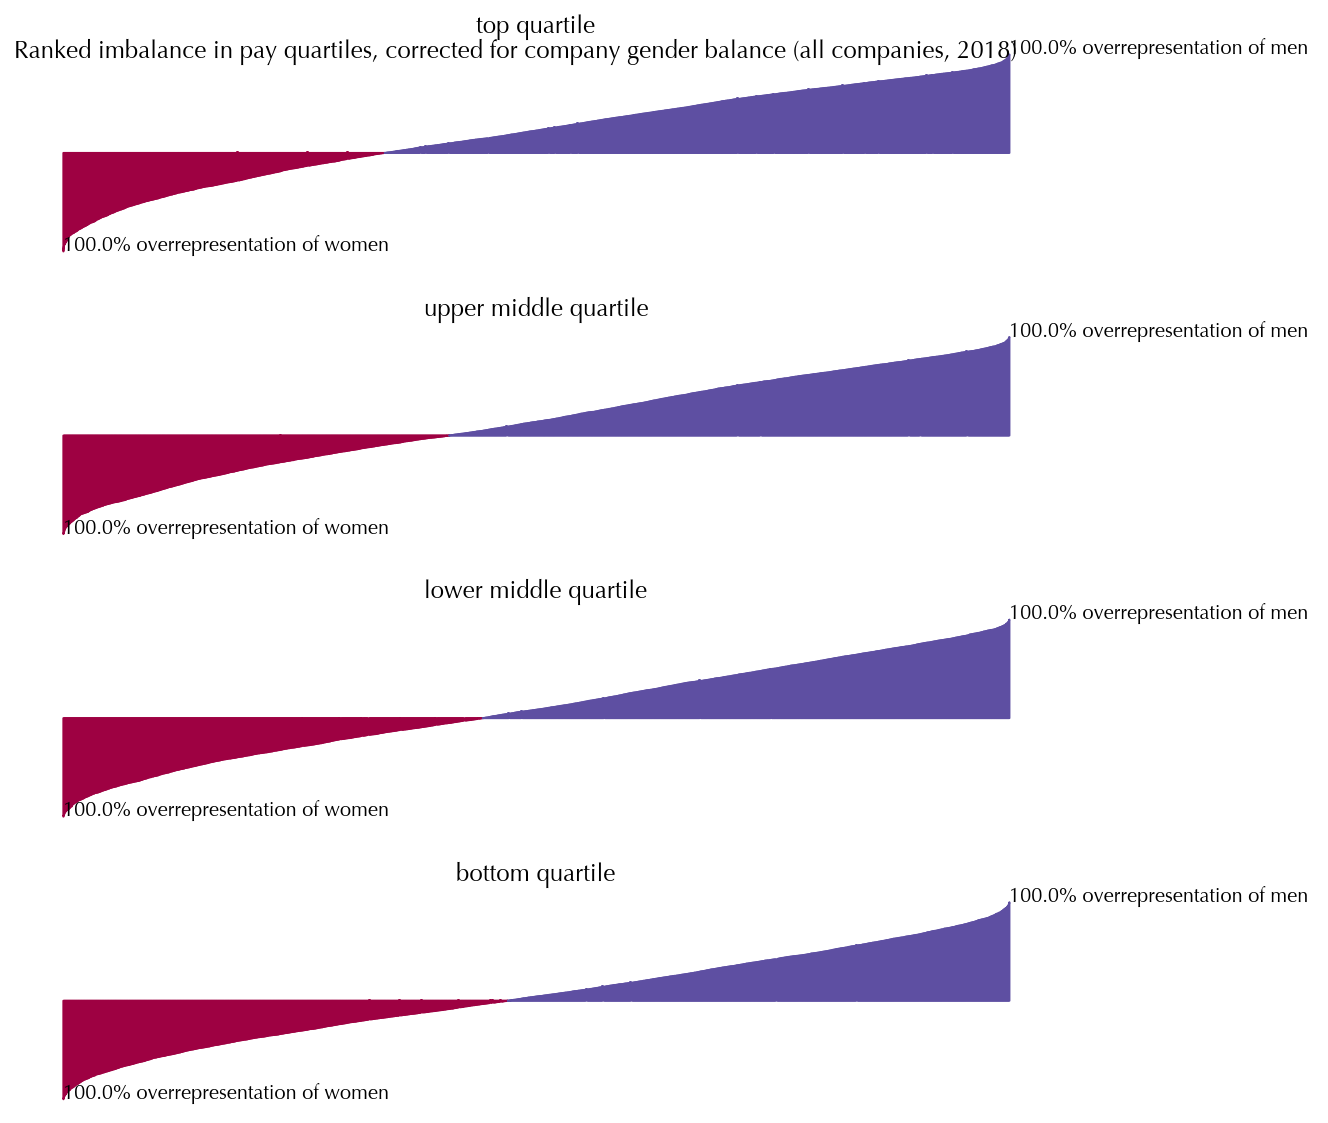

In [644]:
year= 2018


df['q1'] = (df.MaleLowerQuartile * df.MalePerc / 100 - df.FemaleLowerQuartile  * df.FemalePerc / 100) 
df['q2'] = (df.MaleLowerMiddleQuartile * df.MalePerc / 100- df.FemaleLowerMiddleQuartile * df.FemalePerc / 100) 
df['q3'] = (df.MaleUpperMiddleQuartile * df.MalePerc / 100- df.FemaleUpperMiddleQuartile * df.FemalePerc / 100) 
df['q4'] = (df.MaleTopQuartile * df.MalePerc / 100- df.FemaleTopQuartile * df.FemalePerc / 100) 

fig, axs = plt.subplots(4,1,figsize=(8,8))
plt.tight_layout()
fig.patch.set_visible(False)
cmap = plt.cm.Spectral

for idx, metric_and_descr in enumerate((('q4', 'top'), ('q3','upper middle'), ('q2','lower middle'),('q1', 'bottom'))):
    metric, description = metric_and_descr
    ax = axs[idx]
    y = df[df['year'] == year][metric].sort_values().values
    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)

    normalize = colors.Normalize(vmin=min(y), vmax=max(y))
    # plt.plot( x,y, 'k',label=str(year), lw=2)
    ax.axis('off')

    # Select a color map

    STEP_SIZE=10
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=cmap(-1. if y[i] <0 else 1.))
    ax.annotate(xy=(0, y[0]),s='{:.1f}% overrepresentation of women'.format(-y[0]) )
    ax.annotate(xy=(x[-1], y[-1]),s='{:.1f}% overrepresentation of men '.format(y[-1]) )
    ax.set_title('{} quartile'.format(description))    
fig.suptitle('Ranked imbalance in pay quartiles, corrected for company gender balance (all companies, 2018)')

Text(0.5, 1.0, 'Top quartile gender (adjusted for company workforce composition) (all companies, 2018)')

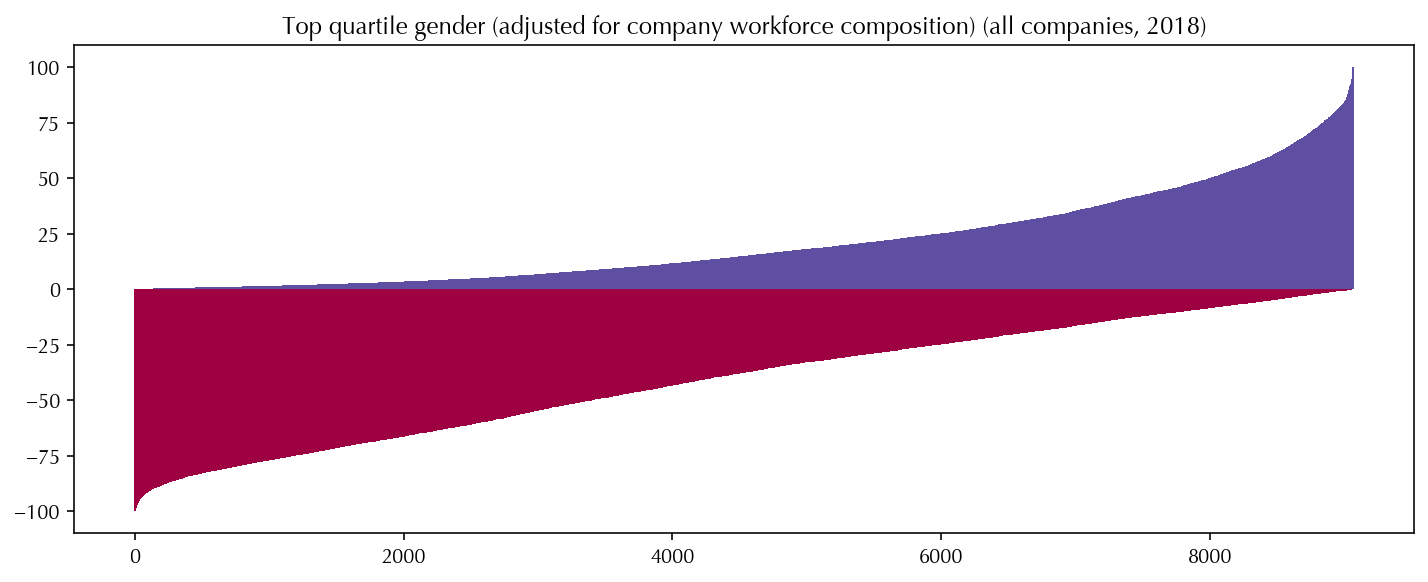

In [569]:
df['t1'] = df.MaleTopQuartile * df.MalePerc / 100
df['t2'] = df.FemaleTopQuartile * df.FemalePerc / 100
df['t3'] = df.t1 - df.t2

fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.tight_layout()
fig.patch.set_visible(False)
cmap = plt.cm.Spectral
yFem = -df[df['year'] == year].sort_values('t3', ascending=False)['t1'].values
yMale = df[df['year'] == year].sort_values('t3', ascending=False)['t2'].values

NUM_POINTS = len(y)
x = np.arange(NUM_POINTS)

normalize = colors.Normalize(vmin=min(y), vmax=max(y))
# plt.plot( x,y, 'k',label=str(year), lw=2)

STEP_SIZE=1
for i in range(0, NUM_POINTS-1, STEP_SIZE):
    ax.fill_between(x[i:i+STEP_SIZE], yFem[i:i+ STEP_SIZE], color=cmap(-1))
    ax.fill_between(x[i:i+STEP_SIZE], yMale[i:i+ STEP_SIZE], color=cmap(1.))

ax.set_title('Top quartile gender (adjusted for company workforce composition) (all companies, 2018)')    


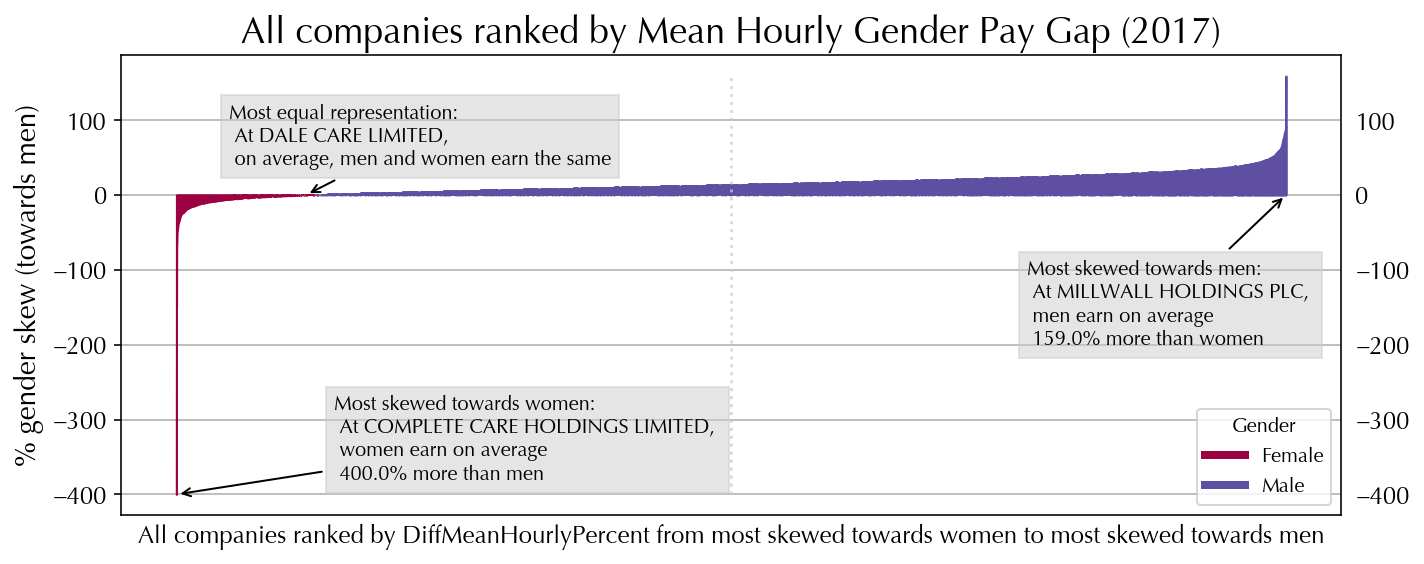

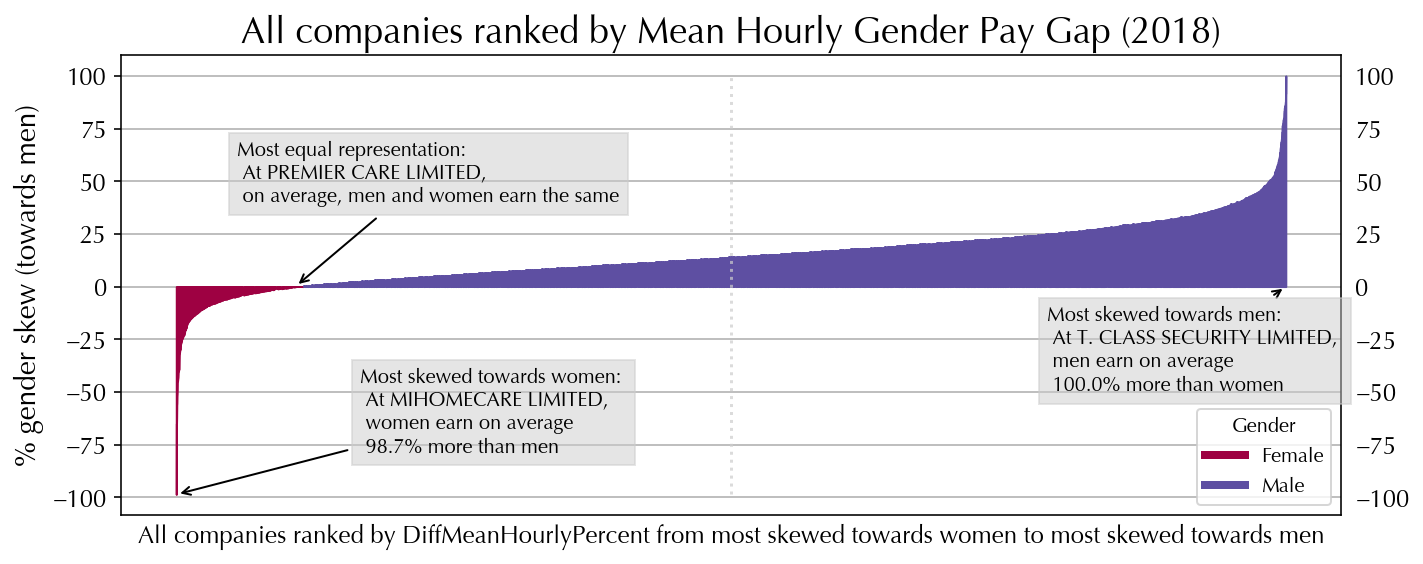

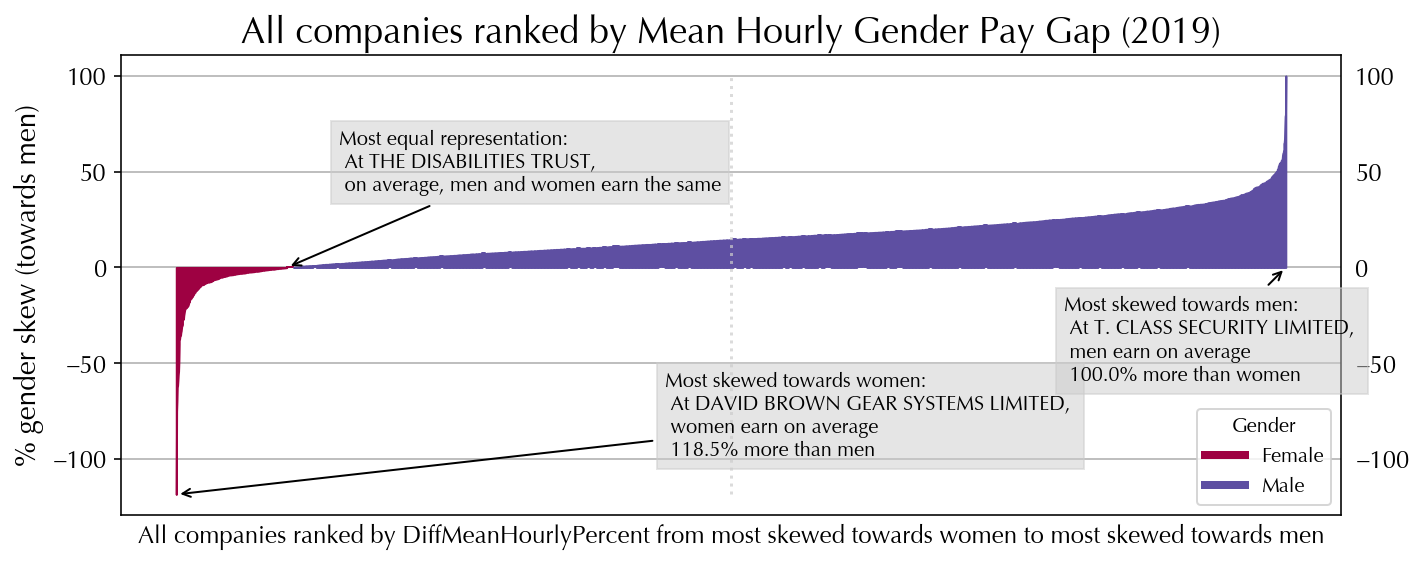

In [647]:
mpl.rcParams['font.family'] = 'Optima'
mpl.rcParams['text.usetex'] = 'False'

cmap = plt.cm.Spectral
STEP_SIZE=10
TRANSPARENT_GRAY=(0.8,0.8,0.8,0.7)
metric = 'DiffMeanHourlyPercent'
sort_by ='DiffMeanHourlyPercent'

for year in YEARS:
    fig, ax = plt.subplots(1,1,figsize=(10,4))
    fig.patch.set_visible(False)
    y = df[df['year'] == year].sort_values(sort_by)[metric].values
    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)
    normalize = colors.Normalize(vmin=min(y), vmax=max(y))

    fairest_idx = np.argmin(abs(y))
    fairest_company = df[df['year'] == year].sort_values(sort_by)['CurrentName'].values[fairest_idx]
    most_women_company = df.loc[df[df['year'] == year][metric].idxmin()]['CurrentName']
    most_women_skew_perc =  -y[0]
    most_men_company = df.loc[df[df['year'] == year][metric].idxmax()]['CurrentName']
    most_men_skew_perc = y[-1]

    # Draw bars for each of the companies
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        color = cmap(-1. if y[i] <0 else 1. if y[i] > 0 else 0)
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=color)

    ax.set_title('All companies ranked by Mean Hourly Gender Pay Gap ({})'.format(year),
                **{ 'fontsize': 18})    

    ax.annotate(xytext=(1500, y[0]+ 20),
                s='Most skewed towards women: \n At {}, \n women earn on average \n {:.1f}% more than men'
                    .format(most_women_company, most_women_skew_perc),
                xy = (x[0], y[0]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(x[-1]-fairest_idx*2 , np.min(y)/2),
                s='Most skewed towards men: \n At {}, \n men earn on average \n {:.1f}% more than women'
                    .format(most_men_company, most_men_skew_perc),
                xy = (x[-1], 0), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(500, 40),
                s='Most equal representation: \n At {}, \n on average, men and women earn the same'
                    .format(fairest_company, y[fairest_idx]),
                xy = (x[fairest_idx], y[fairest_idx]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))
    # A line down the middle as a visual indicator of where skew lies
    ax.plot([NUM_POINTS//2, NUM_POINTS//2], [np.min(y), np.max(y)], ls=':', color=TRANSPARENT_GRAY)

    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xlabel('All companies ranked by {} from most skewed towards women to most skewed towards men'.format(metric),
                 **{'fontsize': 12})
    ax.set_ylabel('% gender skew (towards men)', **{'fontsize': 14})

    plt.xticks([], [], fontsize=12)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=12)
    
    custom_legend = [Line2D([0], [0], color=cmap(0.), lw=4),
        Line2D([0], [0], color=cmap(1.), lw=4)]
    ax.legend(custom_legend, ['Female', 'Male'], title='Gender', loc='lower right')

        
    plt.tight_layout()
    plt.savefig('Visualizations/{}-all-companies-mean.png'.format(year), dpi=150)

ValueError: Image size of 5356867x7866 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

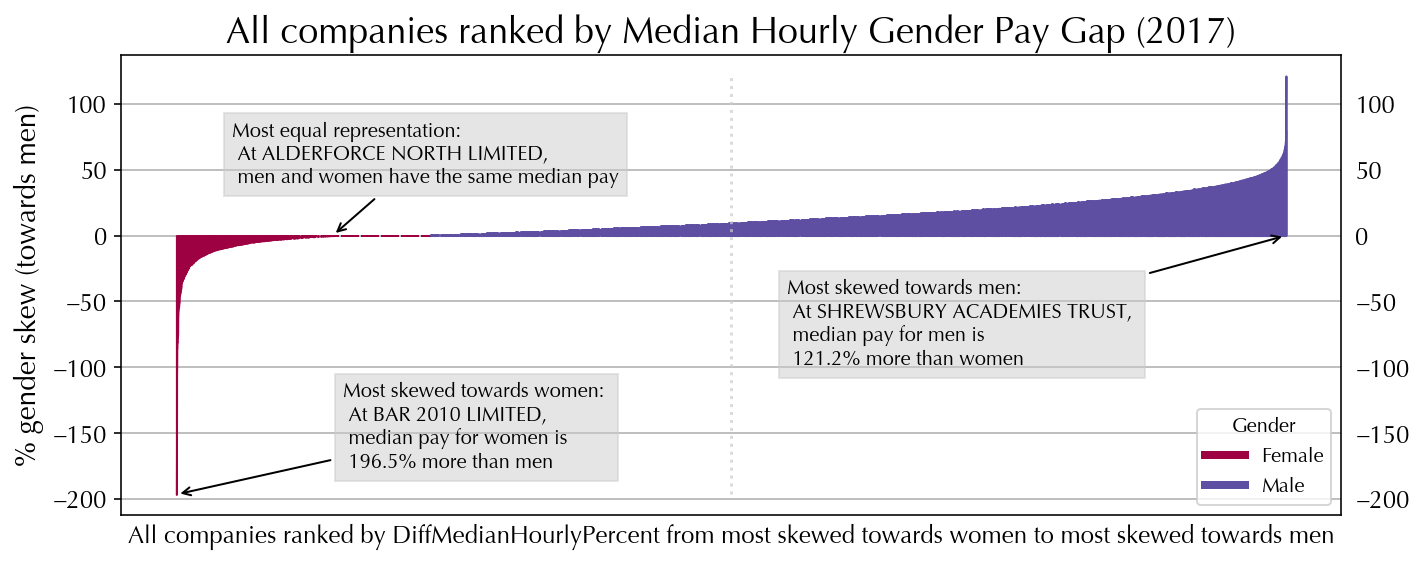

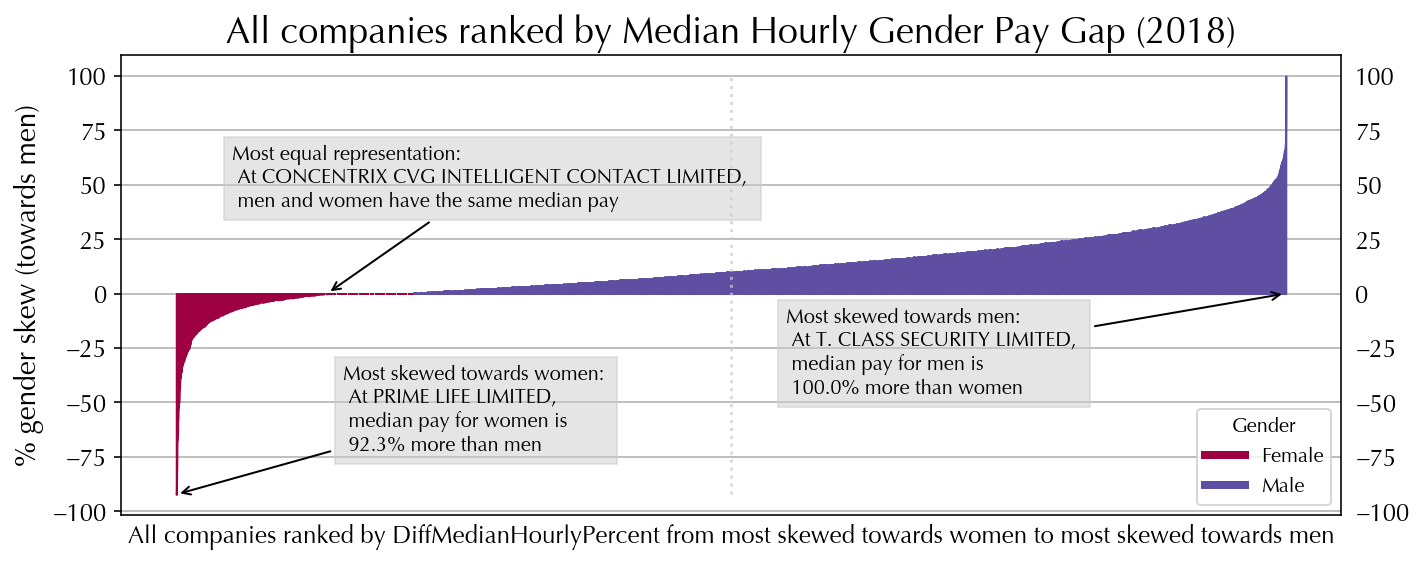

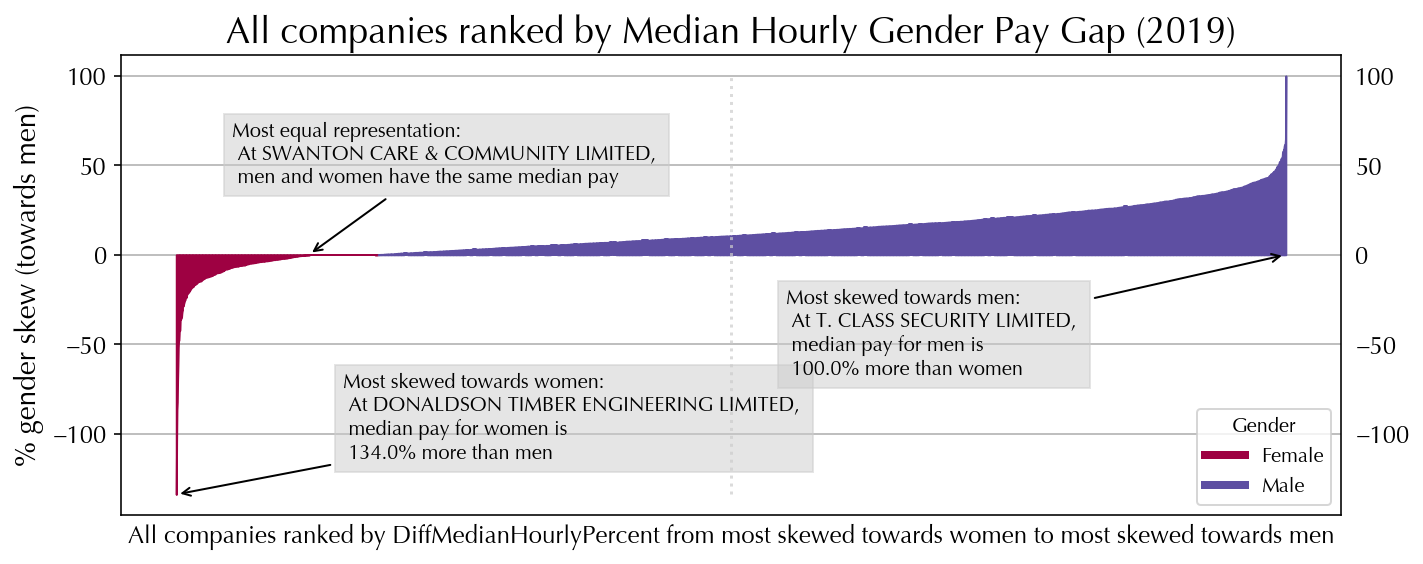

In [649]:



ax.annotate(xy=(40, y[0]+ 20),s='Most skewed towards women: \n median pay for women at {} \n is {:.1f}% more than for men'.format(df.loc[df[df['year'] == year][metric].idxmin()]['CurrentName'], -y[0]) )
ax.annotate(xy=(2000, -20),s='All companies\' median hourly GPG placed side by side, increasing'.format(-y[0]) )
ax.annotate(xy=(x[-1]- 4500, y[-1]-40),s='Most skewed towards men: \n median pay for men at {} \n is {:.1f}% more than women'.format(df.loc[df[df['year'] == year][metric].idxmax()]['CurrentName'], y[-1]) )
plt.annotate(s='', xy=(8000,-17), xytext=(6600,-17), arrowprops=dict(arrowstyle='->'))
ax.set_title('{} quartile'.format(description))    
ax.set_title('All companies ranked by Median Hourly Gender Pay Gap (2018)')   

cmap = plt.cm.Spectral
STEP_SIZE=10
TRANSPARENT_GRAY=(0.8,0.8,0.8,0.7)
metric = 'DiffMedianHourlyPercent'
sort_by ='DiffMedianHourlyPercent'

for year in YEARS:
    fig, ax = plt.subplots(1,1,figsize=(10,4))
    fig.patch.set_visible(False)
    y = df[df['year'] == year].sort_values(sort_by)[metric].values
    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)
    normalize = colors.Normalize(vmin=min(y), vmax=max(y))

    fairest_idx = np.argmin(abs(y))
    fairest_company = df[df['year'] == year].sort_values(sort_by)['CurrentName'].values[fairest_idx]
    most_women_company = df.loc[df[df['year'] == year][metric].idxmin()]['CurrentName']
    most_women_skew_perc =  -y[0]
    most_men_company = df.loc[df[df['year'] == year][metric].idxmax()]['CurrentName']
    most_men_skew_perc = y[-1]

    # Draw bars for each of the companies
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        color = cmap(-1. if y[i] <0 else 1. if y[i] > 0 else 0)
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=color)

    ax.set_title('All companies ranked by Median Hourly Gender Pay Gap ({})'.format(year),
                **{ 'fontsize': 18})    

    ax.annotate(xytext=(.15 * NUM_POINTS, y[0]+ 20),
                s='Most skewed towards women: \n At {}, \n median pay for women is \n {:.1f}% more than men'
                    .format(most_women_company, most_women_skew_perc),
                xy = (x[0], y[0]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(x[-1]-0.45* NUM_POINTS , np.min(y)/2),
                s='Most skewed towards men: \n At {}, \n median pay for men is \n {:.1f}% more than women'
                    .format(most_men_company, most_men_skew_perc),
                xy = (x[-1], 0), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(0.05 * NUM_POINTS, 40),
                s='Most equal representation: \n At {}, \n men and women have the same median pay'
                    .format(fairest_company, y[fairest_idx]),
                xy = (x[fairest_idx], y[fairest_idx]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 10},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))
    # A line down the middle as a visual indicator of where skew lies
    ax.plot([NUM_POINTS//2, NUM_POINTS//2], [np.min(y), np.max(y)], ls=':', color=TRANSPARENT_GRAY)

    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xlabel('All companies ranked by {} from most skewed towards women to most skewed towards men'.format(metric),
                 **{'fontsize': 12})
    ax.set_ylabel('% gender skew (towards men)', **{'fontsize': 14})

    custom_legend = [Line2D([0], [0], color=cmap(0.), lw=4),
        Line2D([0], [0], color=cmap(1.), lw=4)]
    ax.legend(custom_legend, ['Female', 'Male'], title='Gender', loc='lower right')
    
    plt.xticks([], [], fontsize=12)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=12)
    plt.tight_layout()
    plt.savefig('Visualizations/{}-all-companies-median.png'.format(year), dpi=150)

Text(0.5, 0.98, 'Ranked imbalance in pay quartiles (2018)')

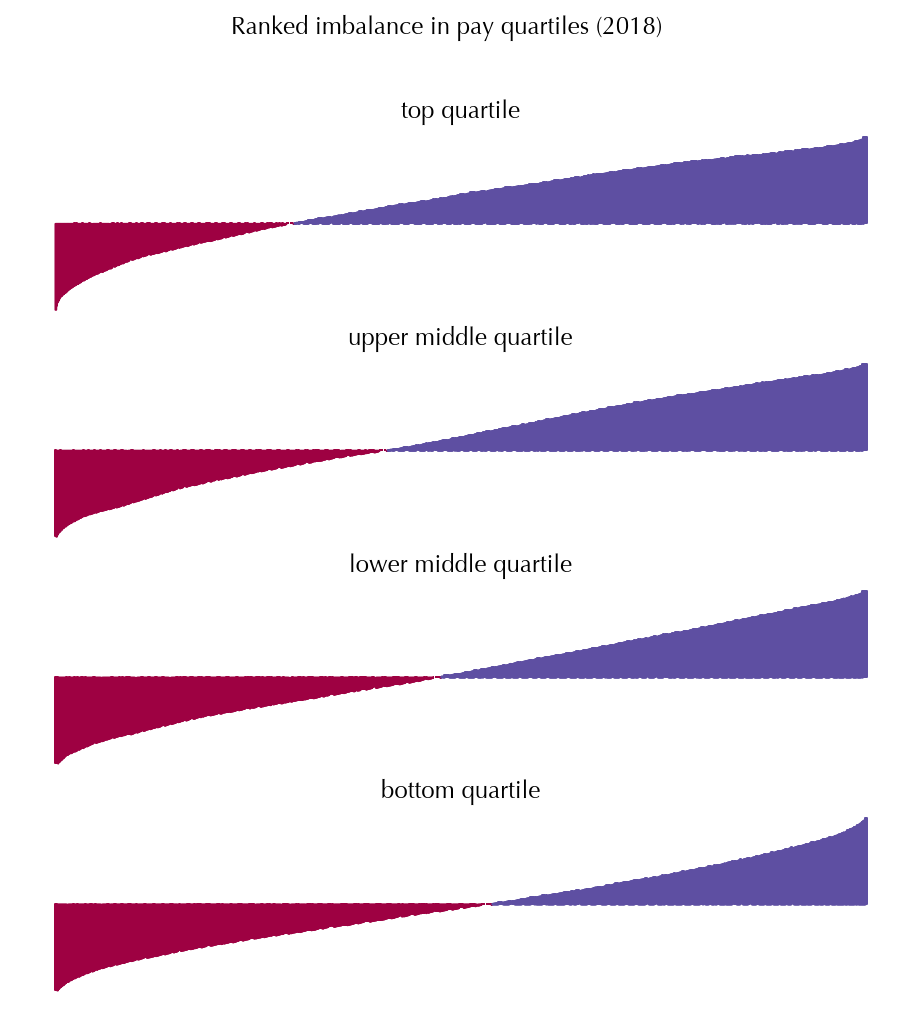

In [572]:
year= 2018


df['q1'] = (df.MaleLowerQuartile - df.FemaleLowerQuartile ) 
df['q2'] = (df.MaleLowerMiddleQuartile - df.FemaleLowerMiddleQuartile ) 
df['q3'] = (df.MaleUpperMiddleQuartile- df.FemaleUpperMiddleQuartile) 
df['q4'] = (df.MaleTopQuartile - df.FemaleTopQuartile ) 

fig, axs = plt.subplots(4,1,figsize=(8,8))
fig.patch.set_visible(False)
cmap = plt.cm.Spectral

for idx, metric_and_descr in enumerate((('q4', 'top'), ('q3','upper middle'), ('q2','lower middle'),('q1', 'bottom'))):
    metric, description = metric_and_descr
    ax = axs[idx]
    y = df[df['year'] == year][metric].sort_values().values
    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)

    normalize = colors.Normalize(vmin=min(y), vmax=max(y))
    # plt.plot( x,y, 'k',label=str(year), lw=2)
    ax.axis('off')

    # Select a color map

    STEP_SIZE=10
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color = cmap(-1. if y[i] <0 else 1. if y[i] > 0 else 0))

    ax.set_title('{} quartile'.format(description))    
fig.suptitle('Ranked imbalance in pay quartiles (2018)')

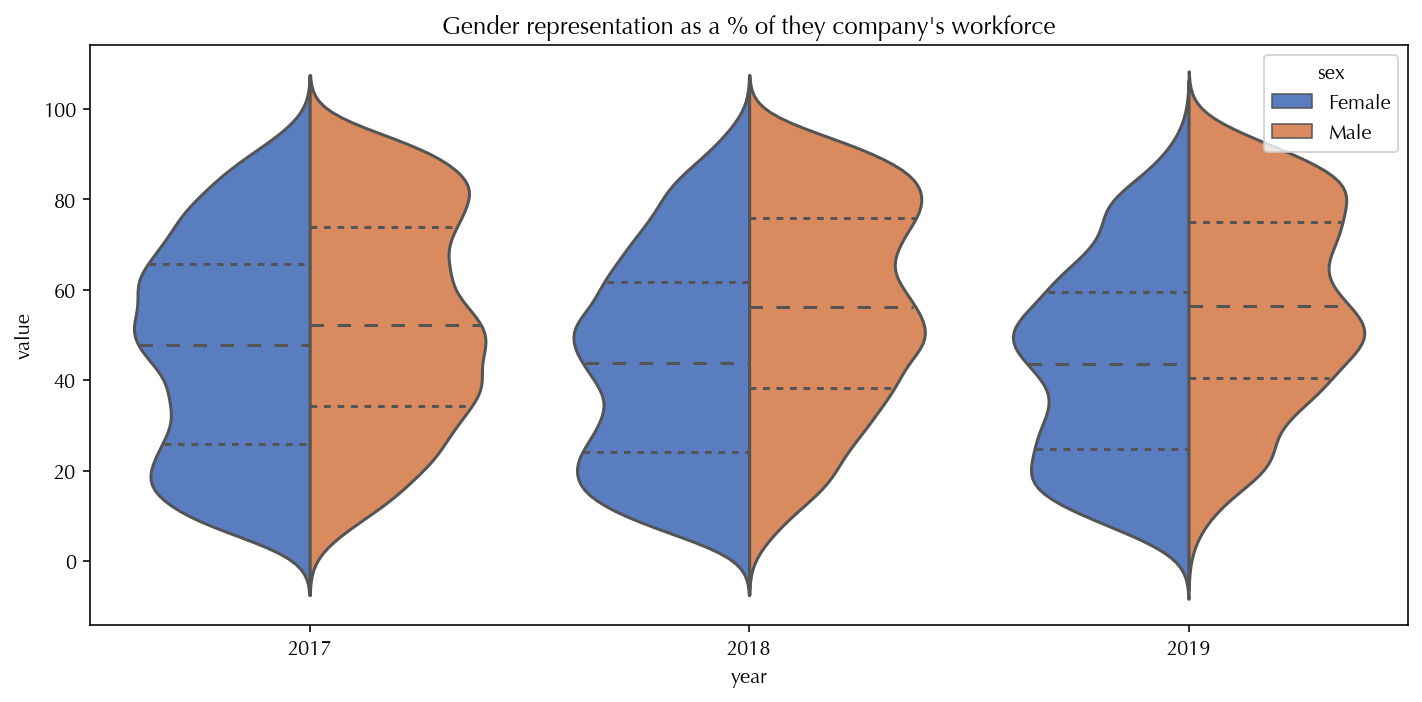

In [573]:
df2 = df[['CurrentName','year', 'FemalePerc', 'MalePerc']].melt(id_vars =['CurrentName', 'year'])
df2['sex'] = df2['variable'].map(lambda x: 'Male' if x == 'MalePerc' else 'Female')
del df2['variable']
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.violinplot(ax=ax, y="value", x="year", split=True, hue='sex', 
                     data=df2, palette="muted",inner='quartile')
ax.set_title('Gender representation as a % of they company\'s workforce')
plt.tight_layout()

Text(0, 0.5, 'Number of companies')

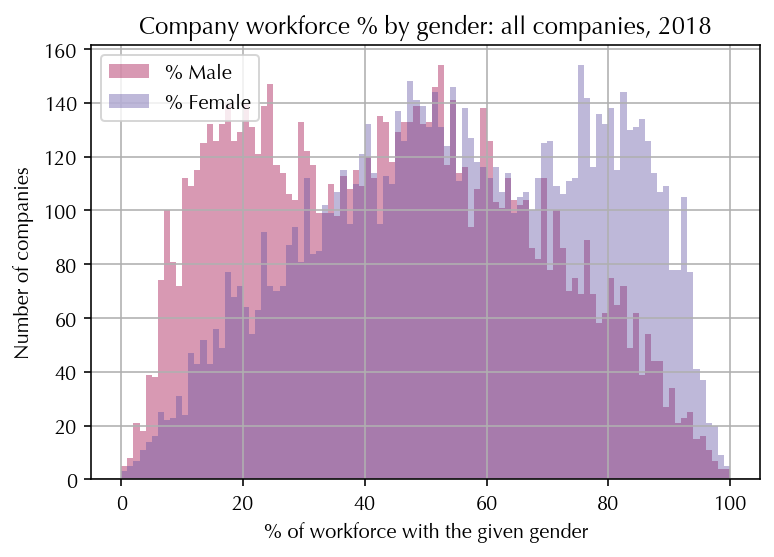

In [574]:
cmap = plt.cm.Spectral
normalize = colors.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1,1, figsize=(6,4))
df[df['year']==2018]['FemalePerc'].hist(bins=100, ax=ax, alpha=0.4, label='% Male', color=cmap(normalize(0)))
df[df['year']==2018]['MalePerc'].hist(bins=100, ax=ax, alpha=0.4, label='% Female', color=cmap(normalize(1)))
ax.legend()
ax.set_title('Company workforce % by gender: all companies, 2018')
ax.set_xlabel('% of workforce with the given gender')
ax.set_ylabel('Number of companies')


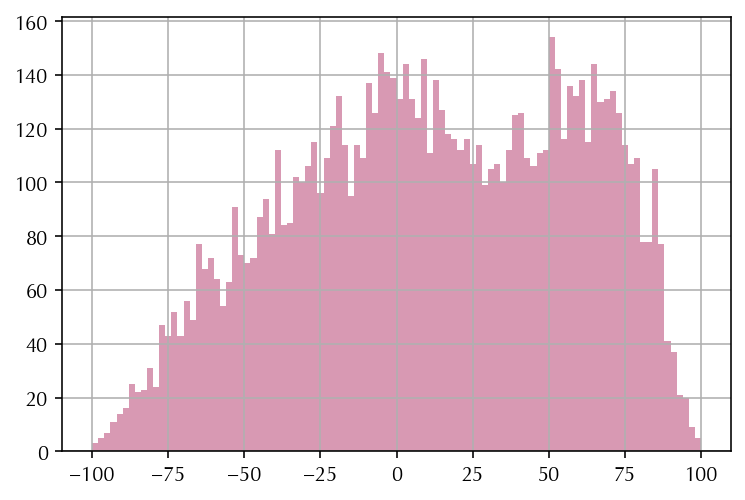

In [575]:
df[df['year']==2018]['GenderSkew'].hist(bins=100, alpha=0.4, label='% diff in gender', color=cmap(normalize(0)))


In [576]:
df[df['year']==2018]['GenderSkew'].describe()

count    9068.000000
mean       11.599007
std        46.245431
min      -100.000000
25%       -23.550000
50%        12.275000
75%        51.600000
max       100.000000
Name: GenderSkew, dtype: float64

/Users/thor/.local/share/virtualenvs/data-exploration-2gHAQ7Cz/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/thor/.local/share/virtualenvs/data-exploration-2gHAQ7Cz/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/thor/.local/share/virtualenvs/data-exploration-2gHAQ7Cz/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a co

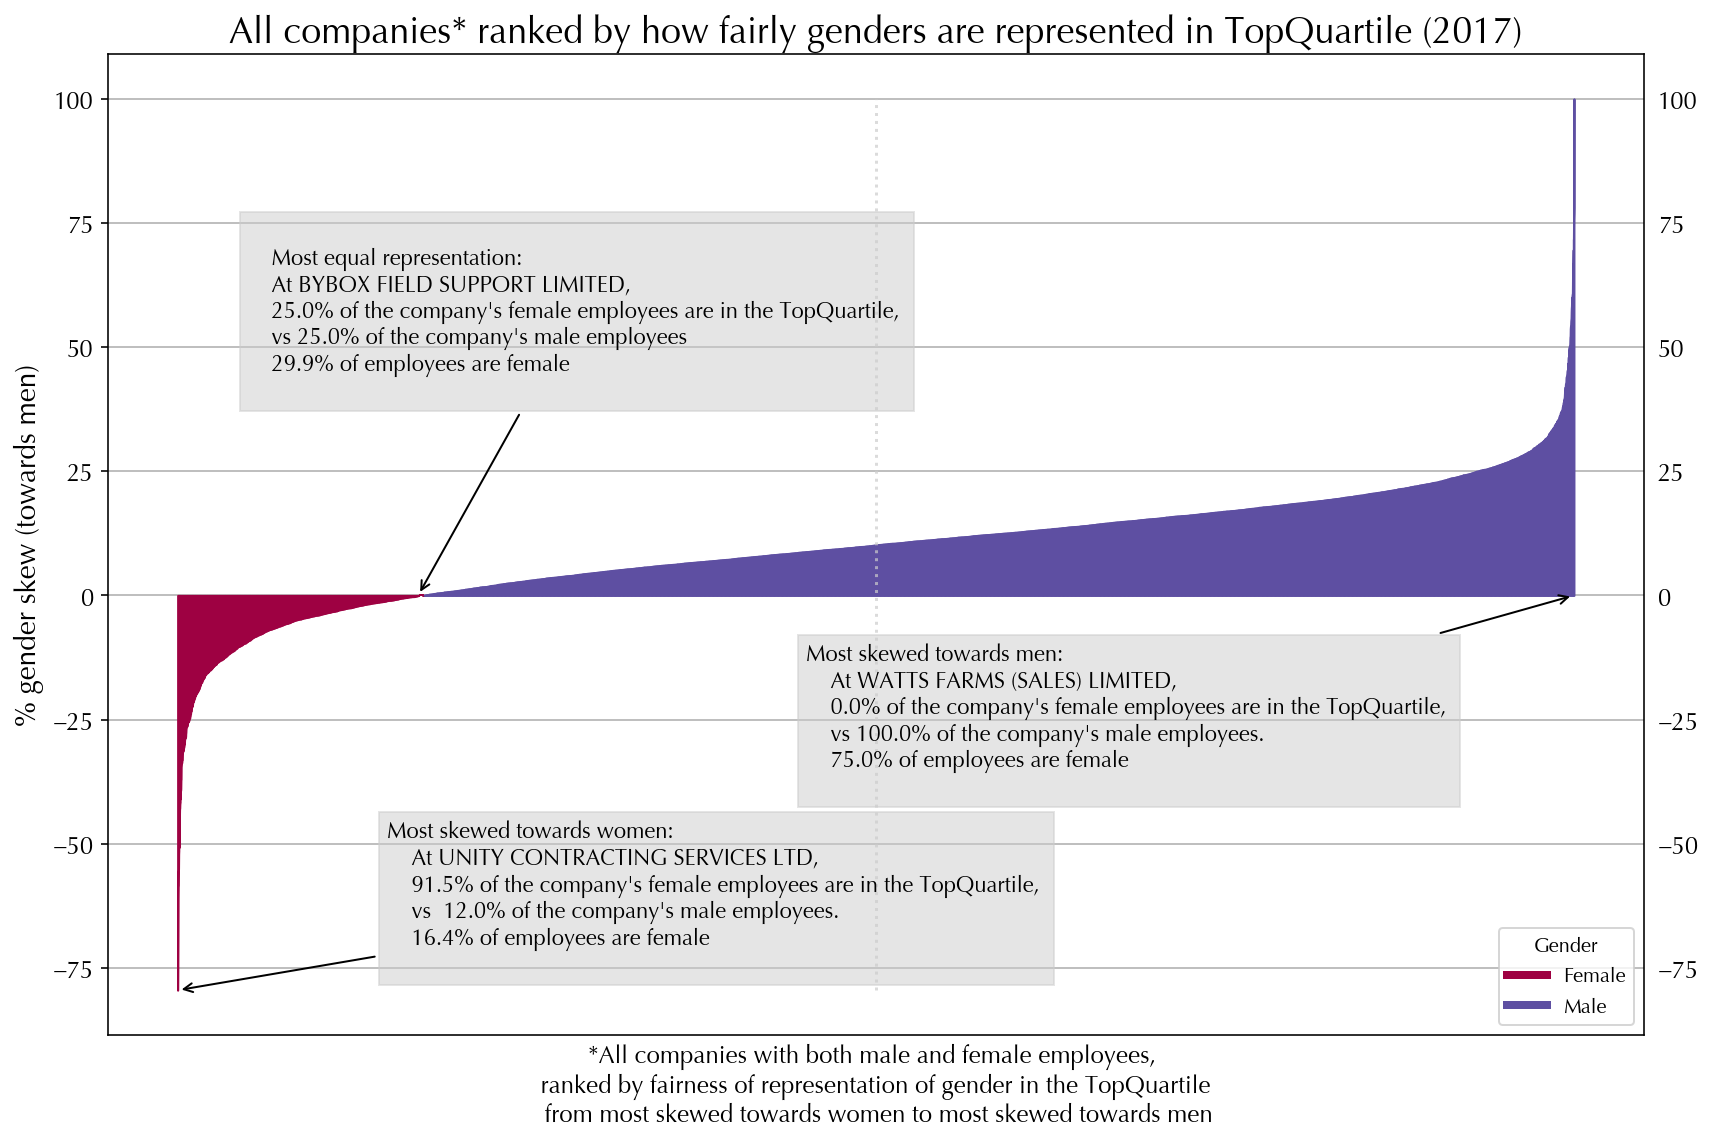

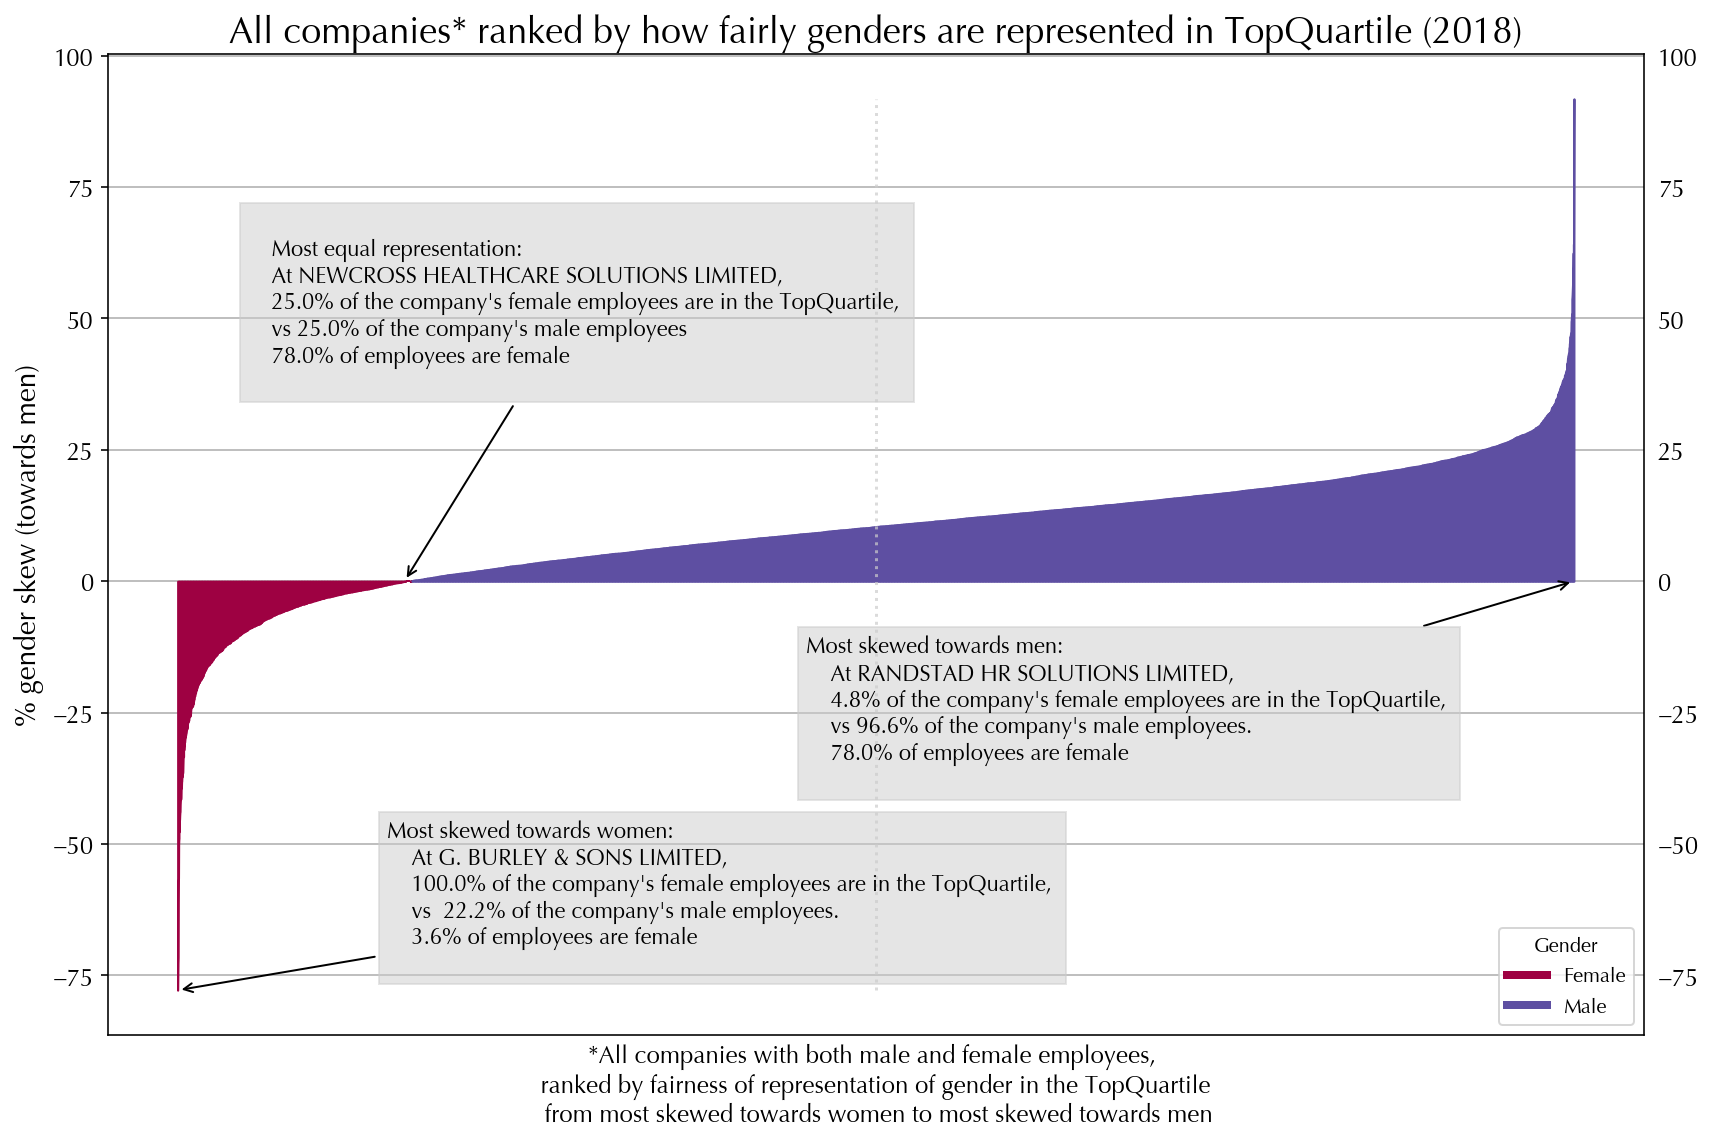

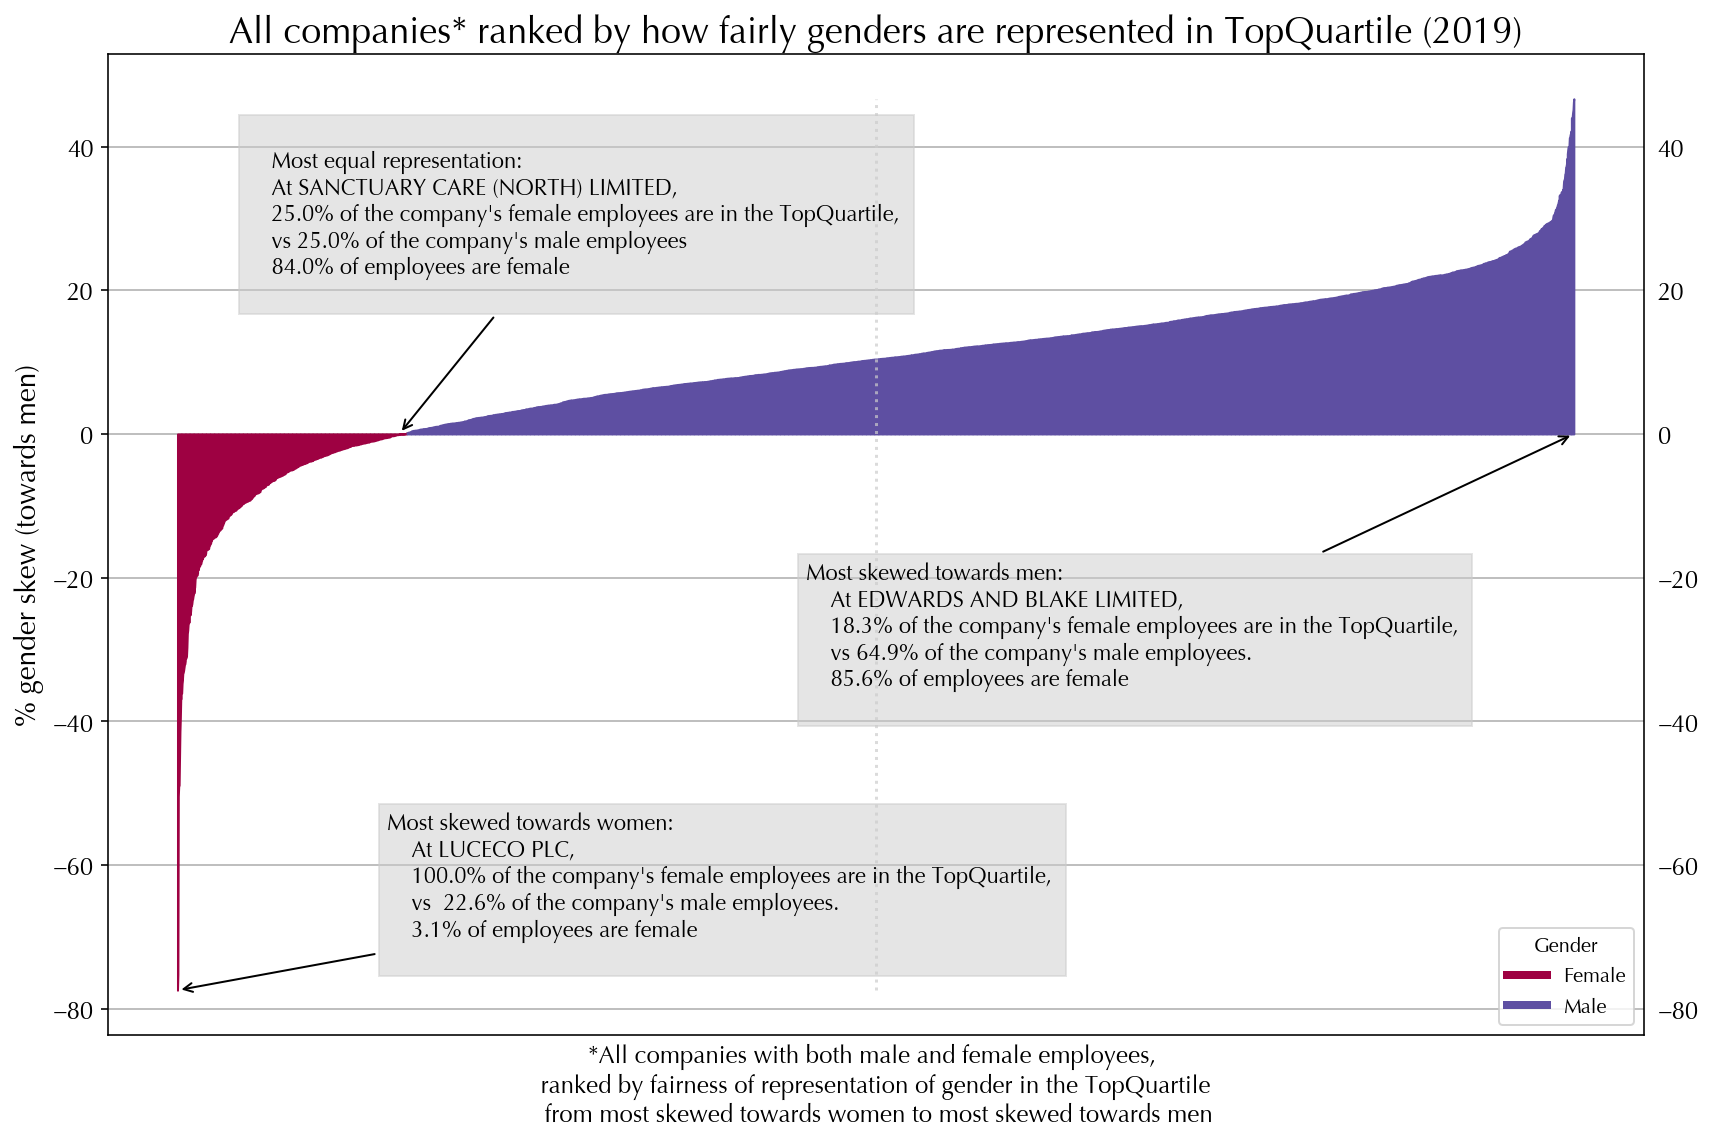

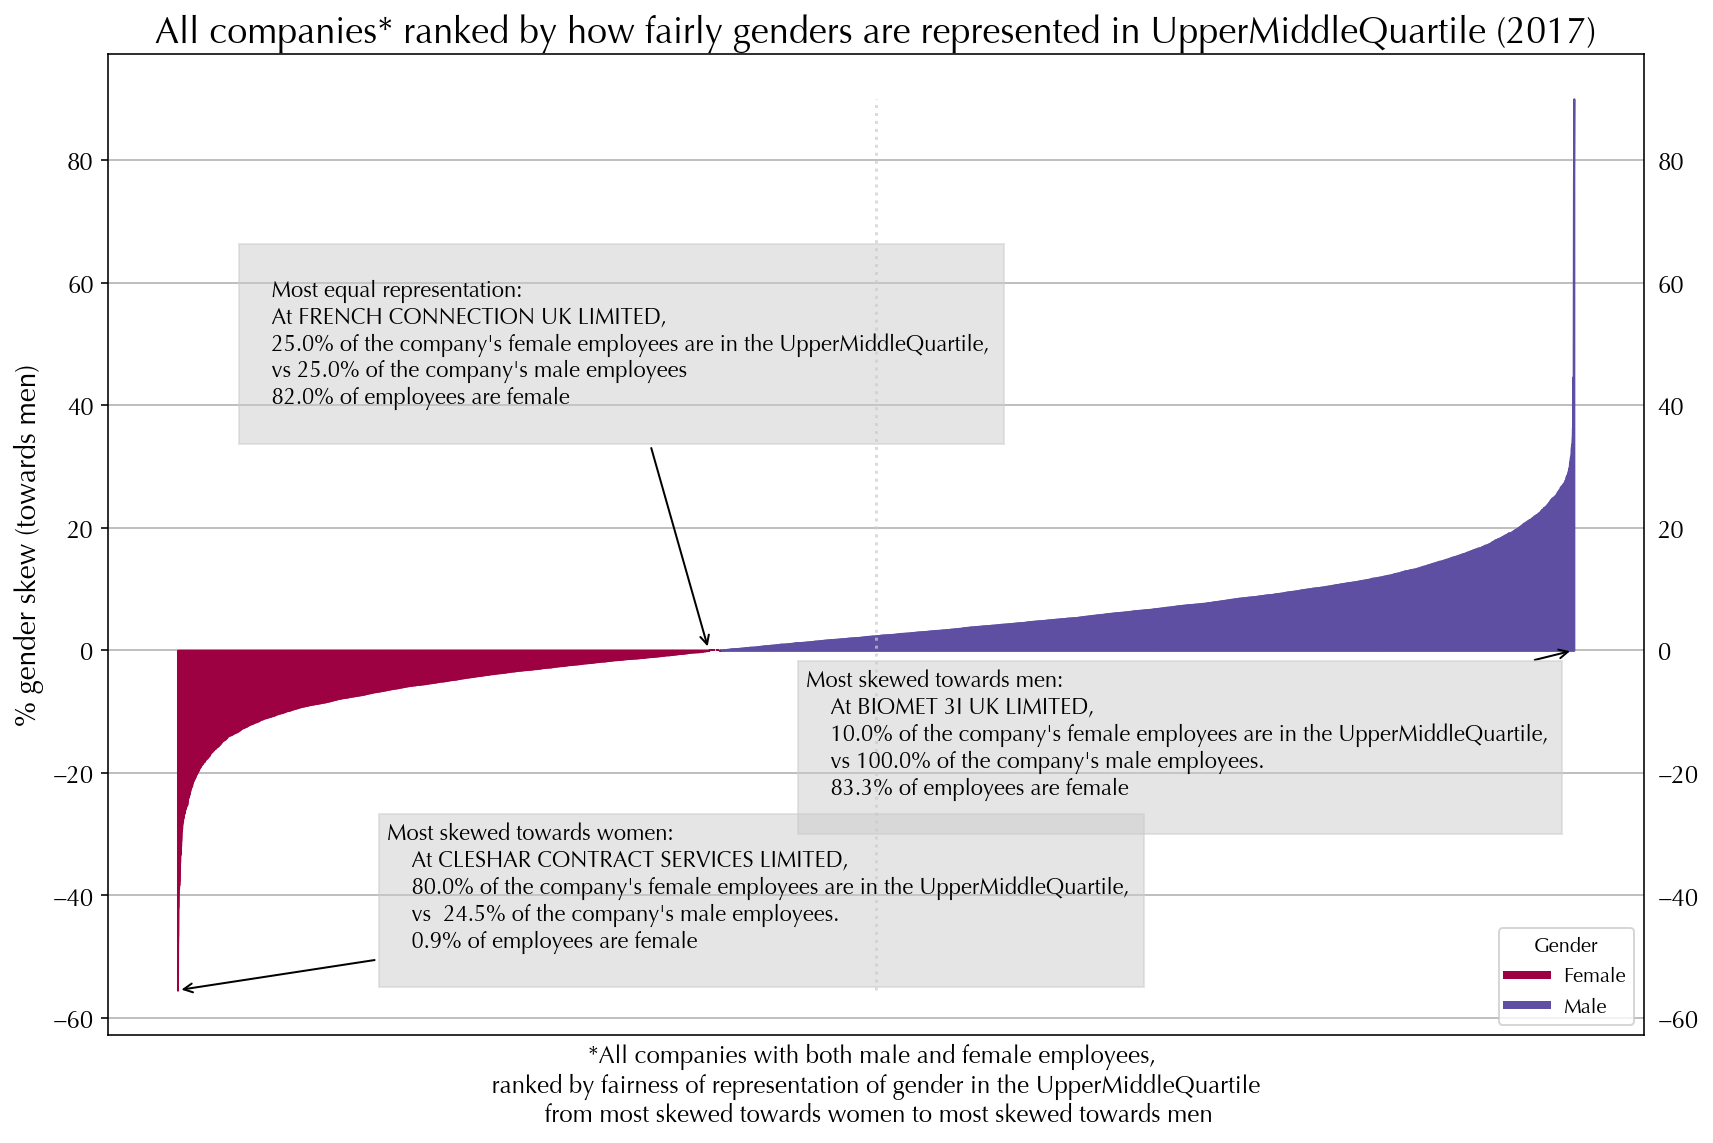

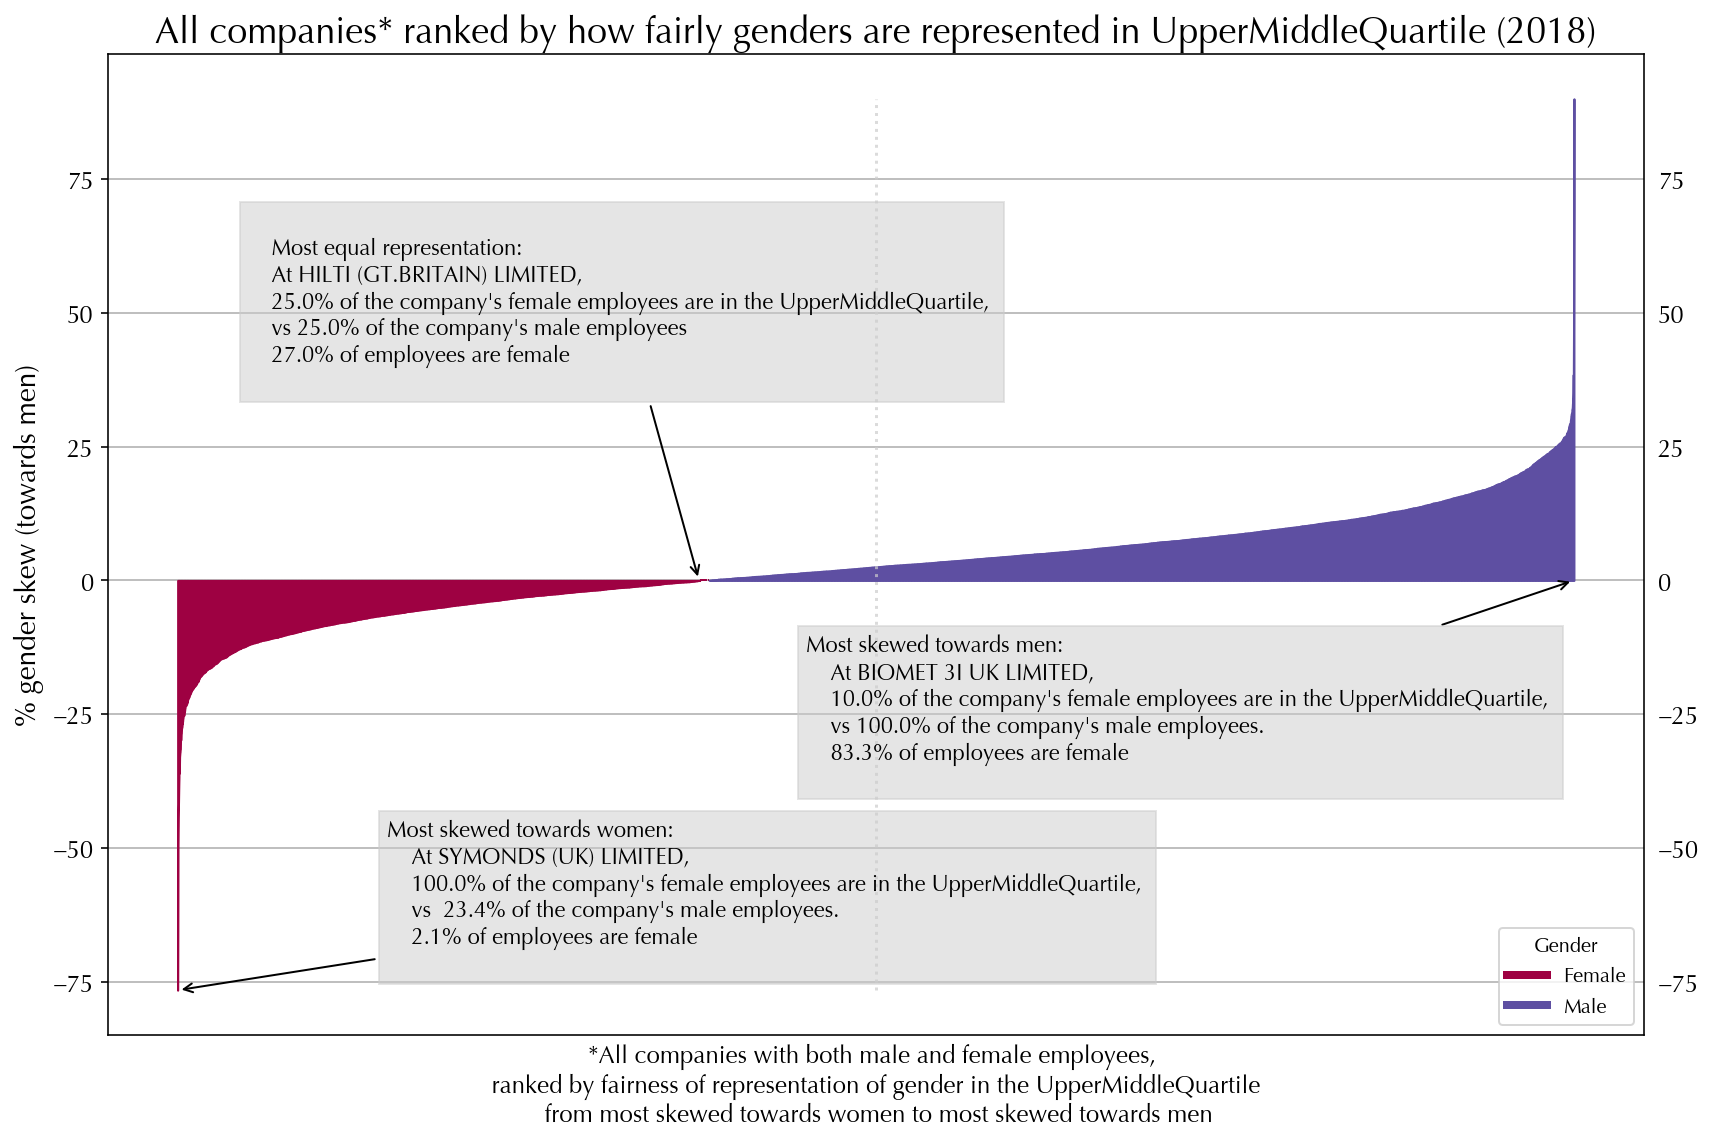

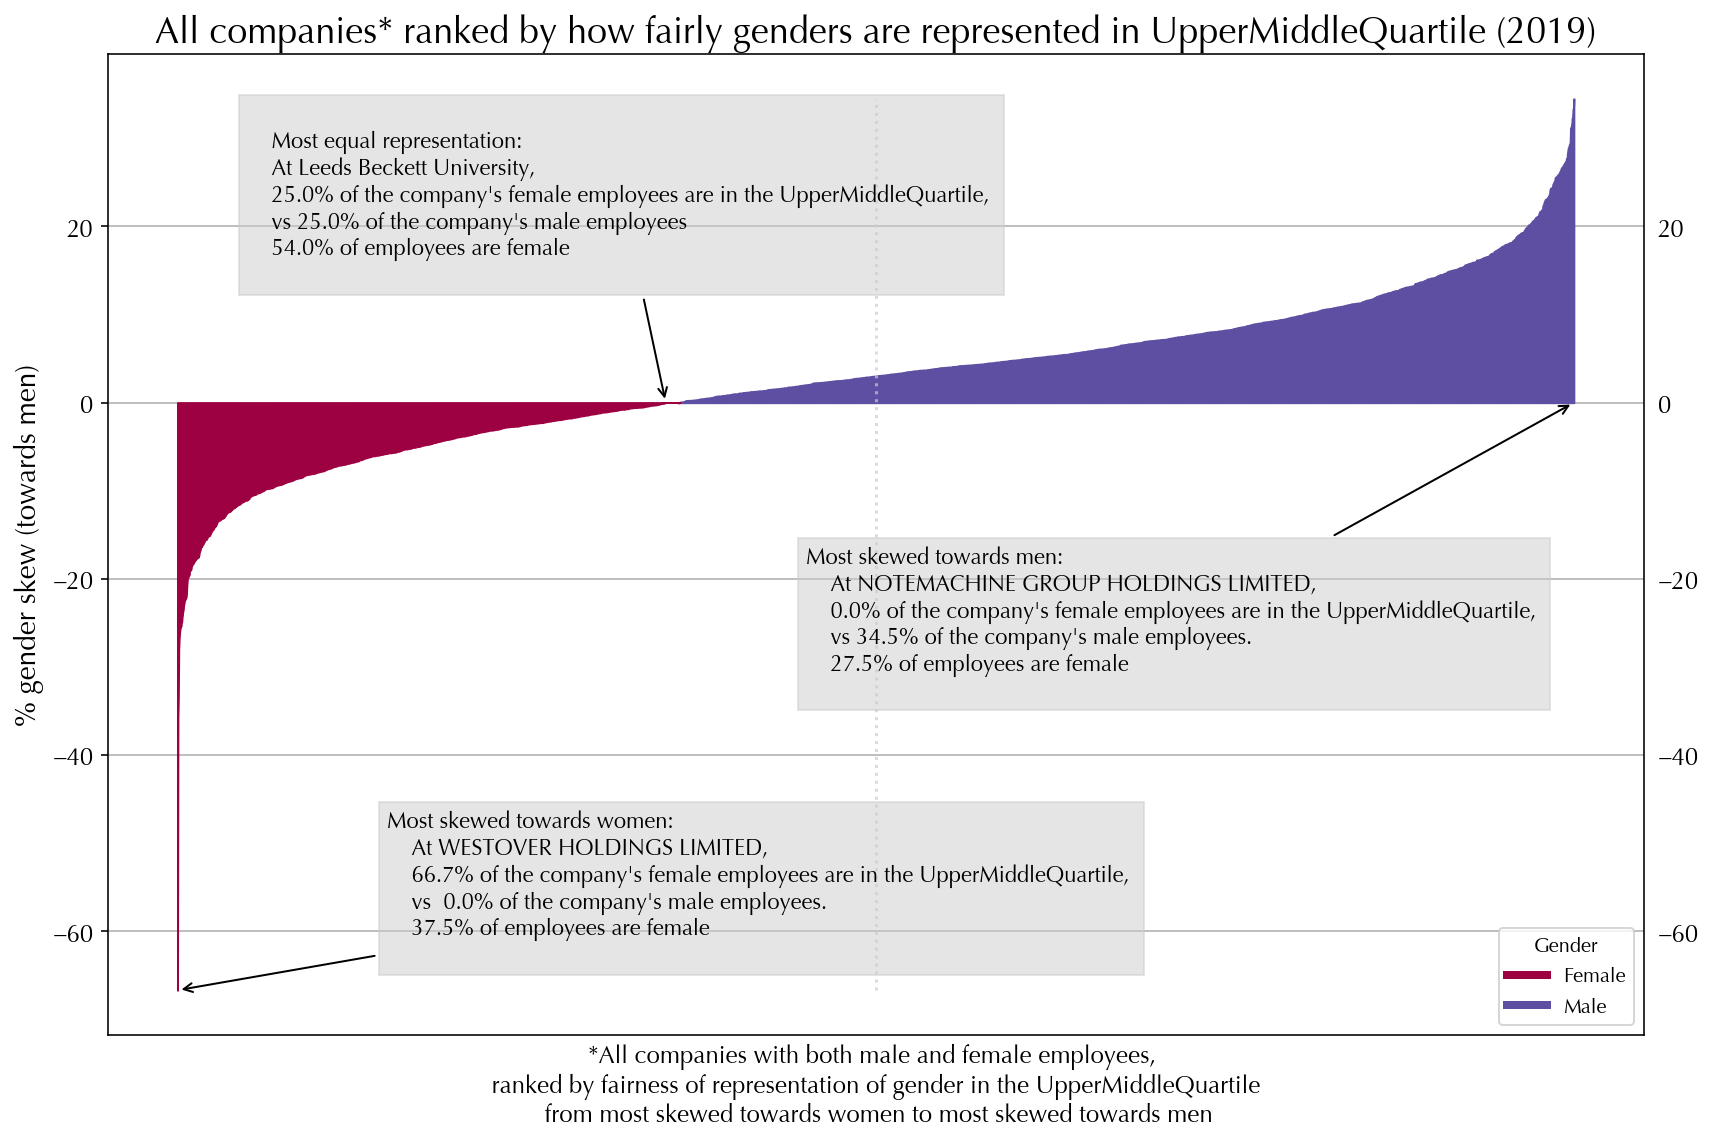

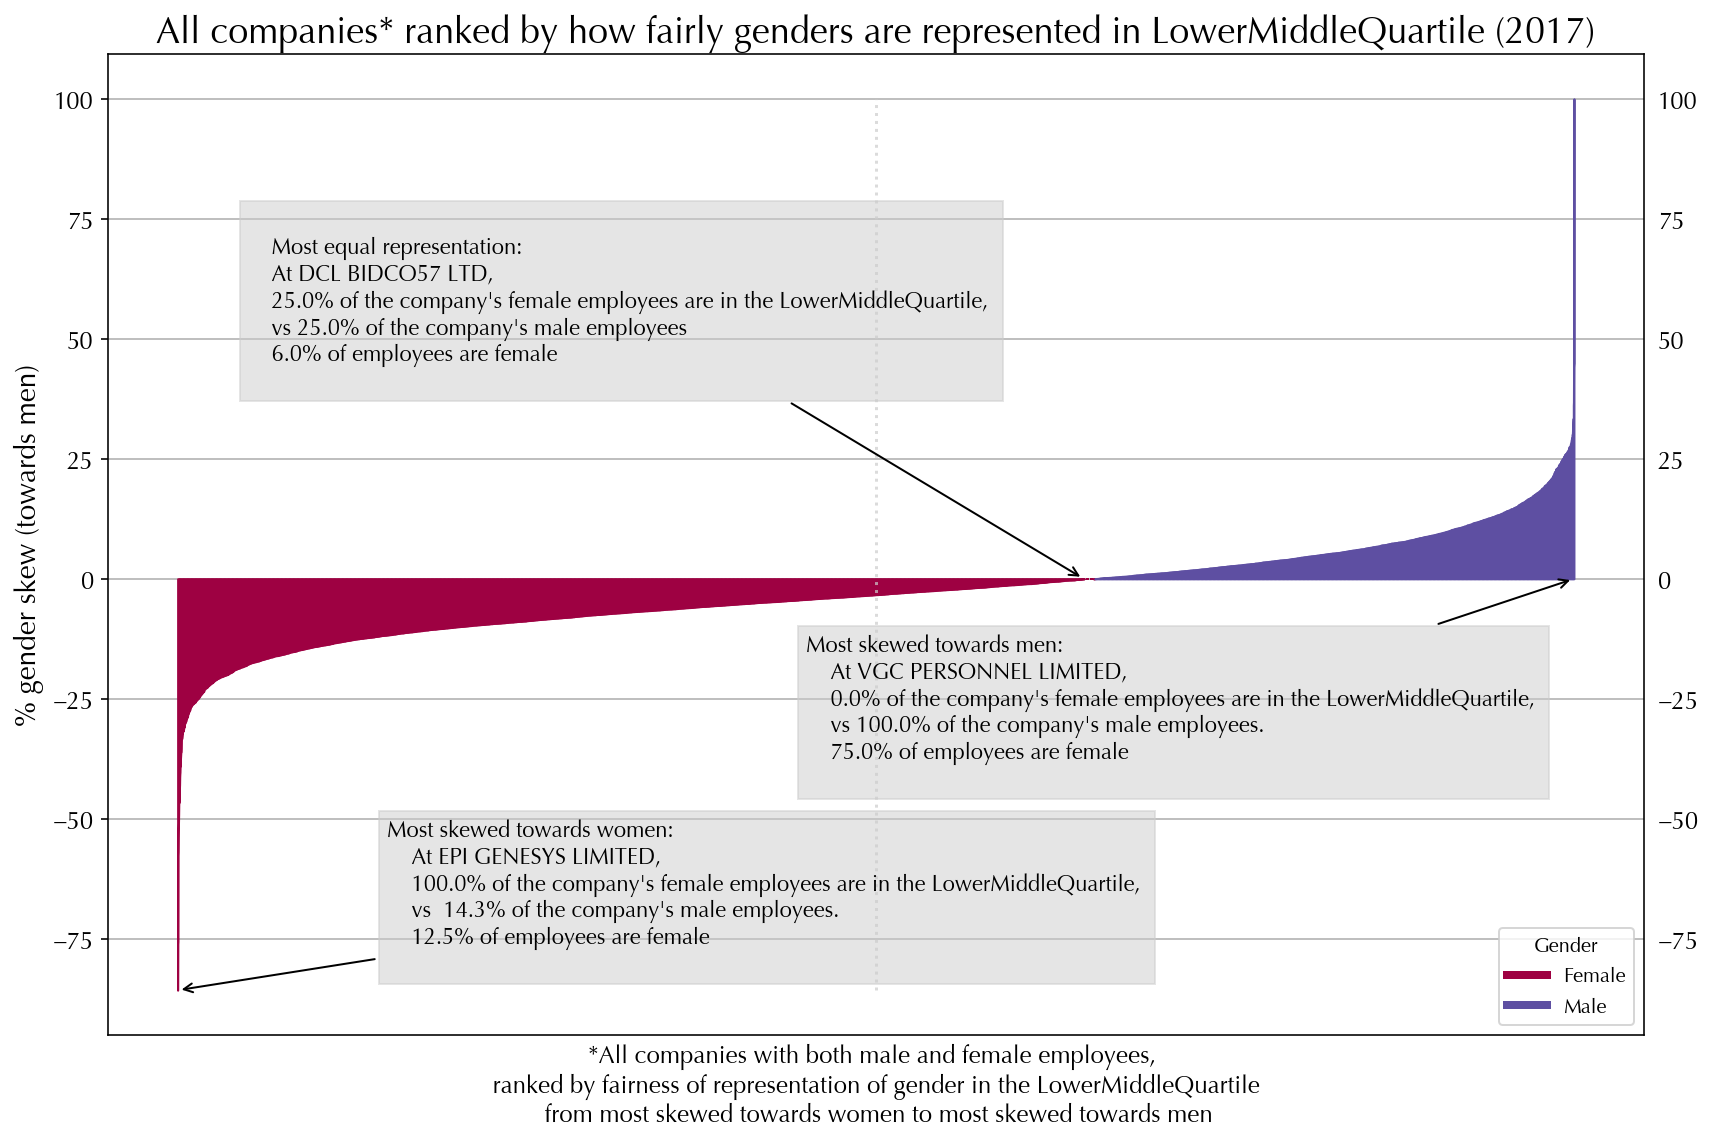

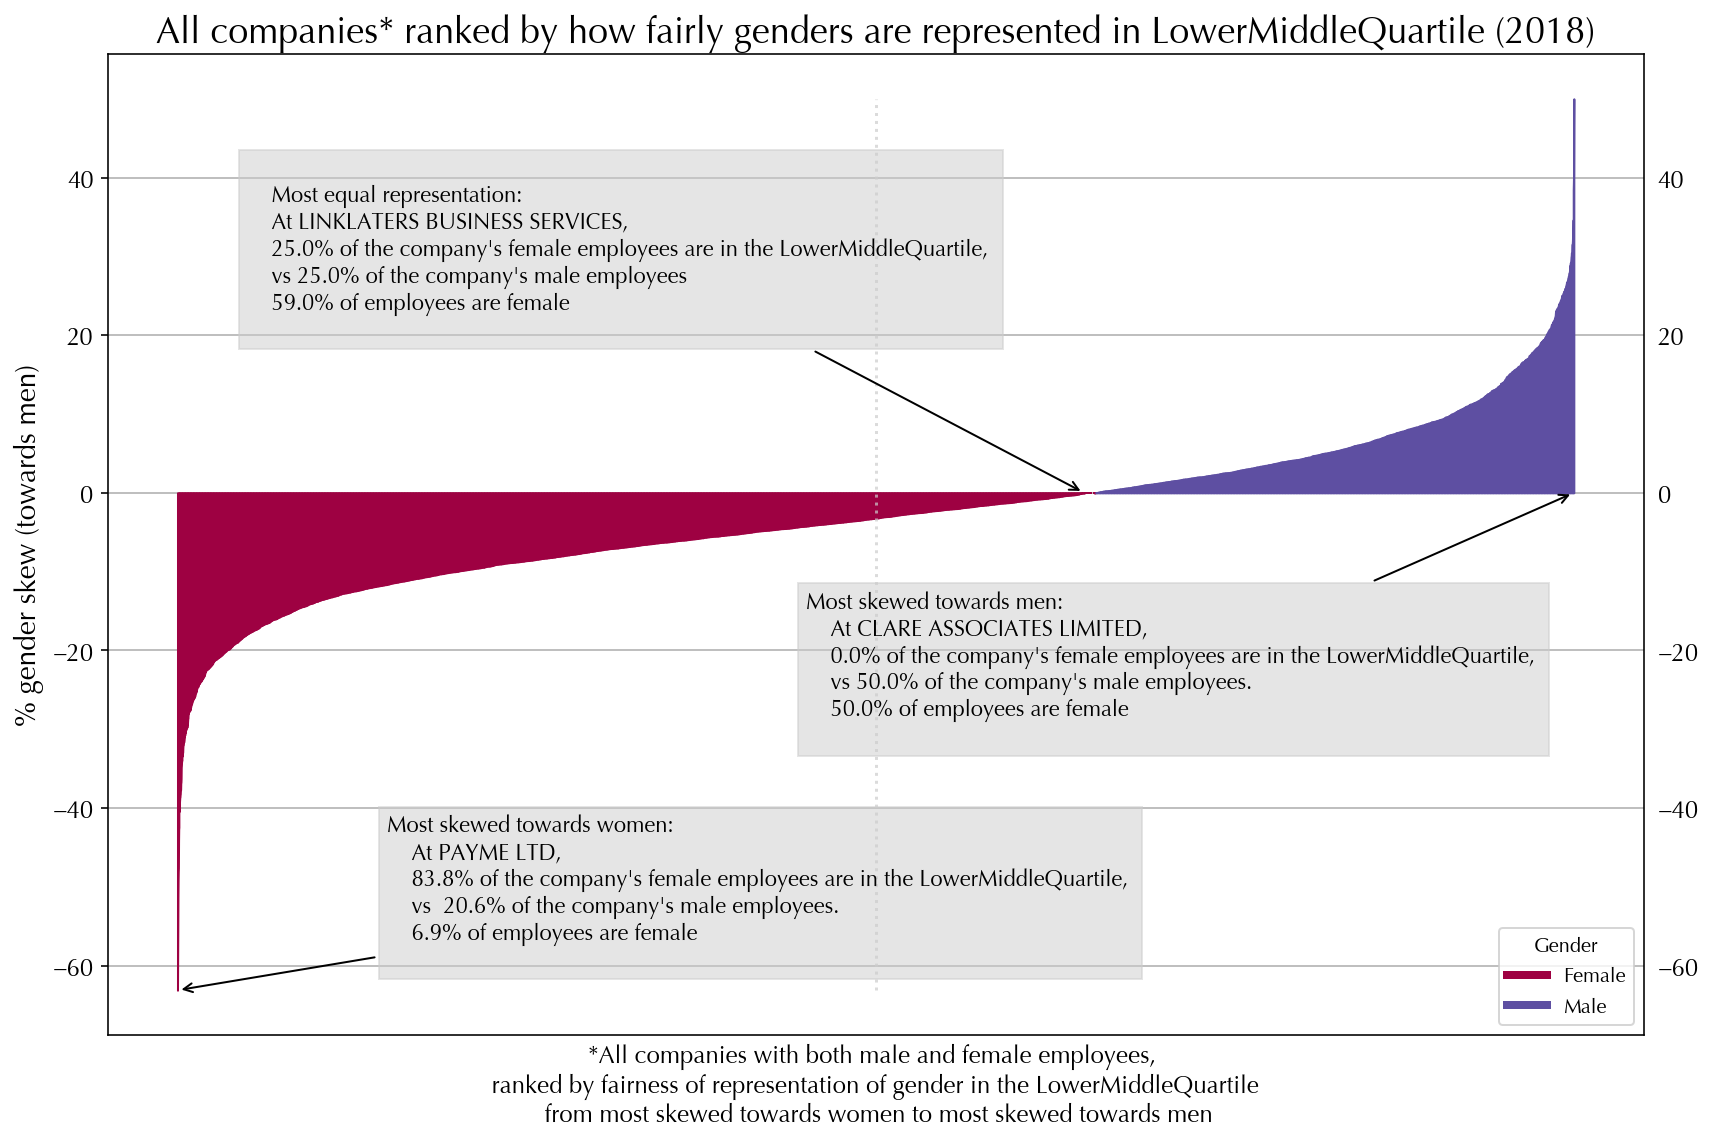

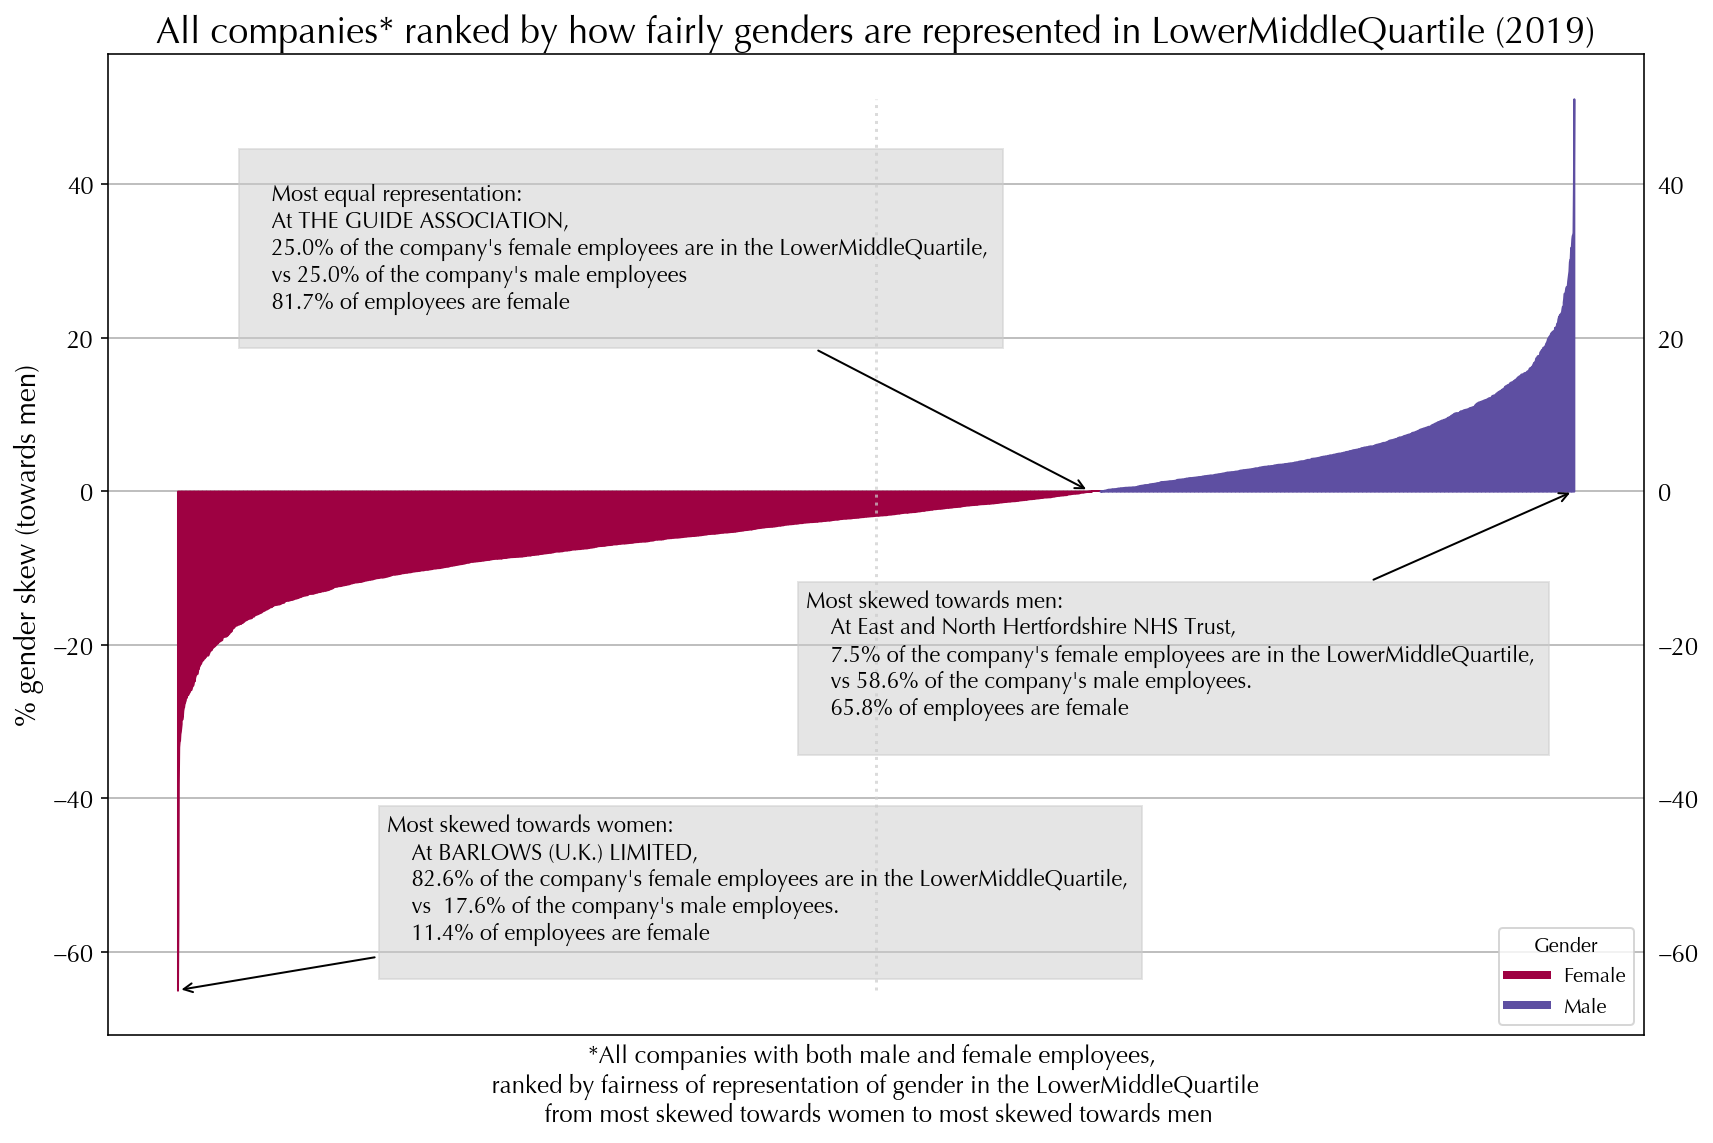

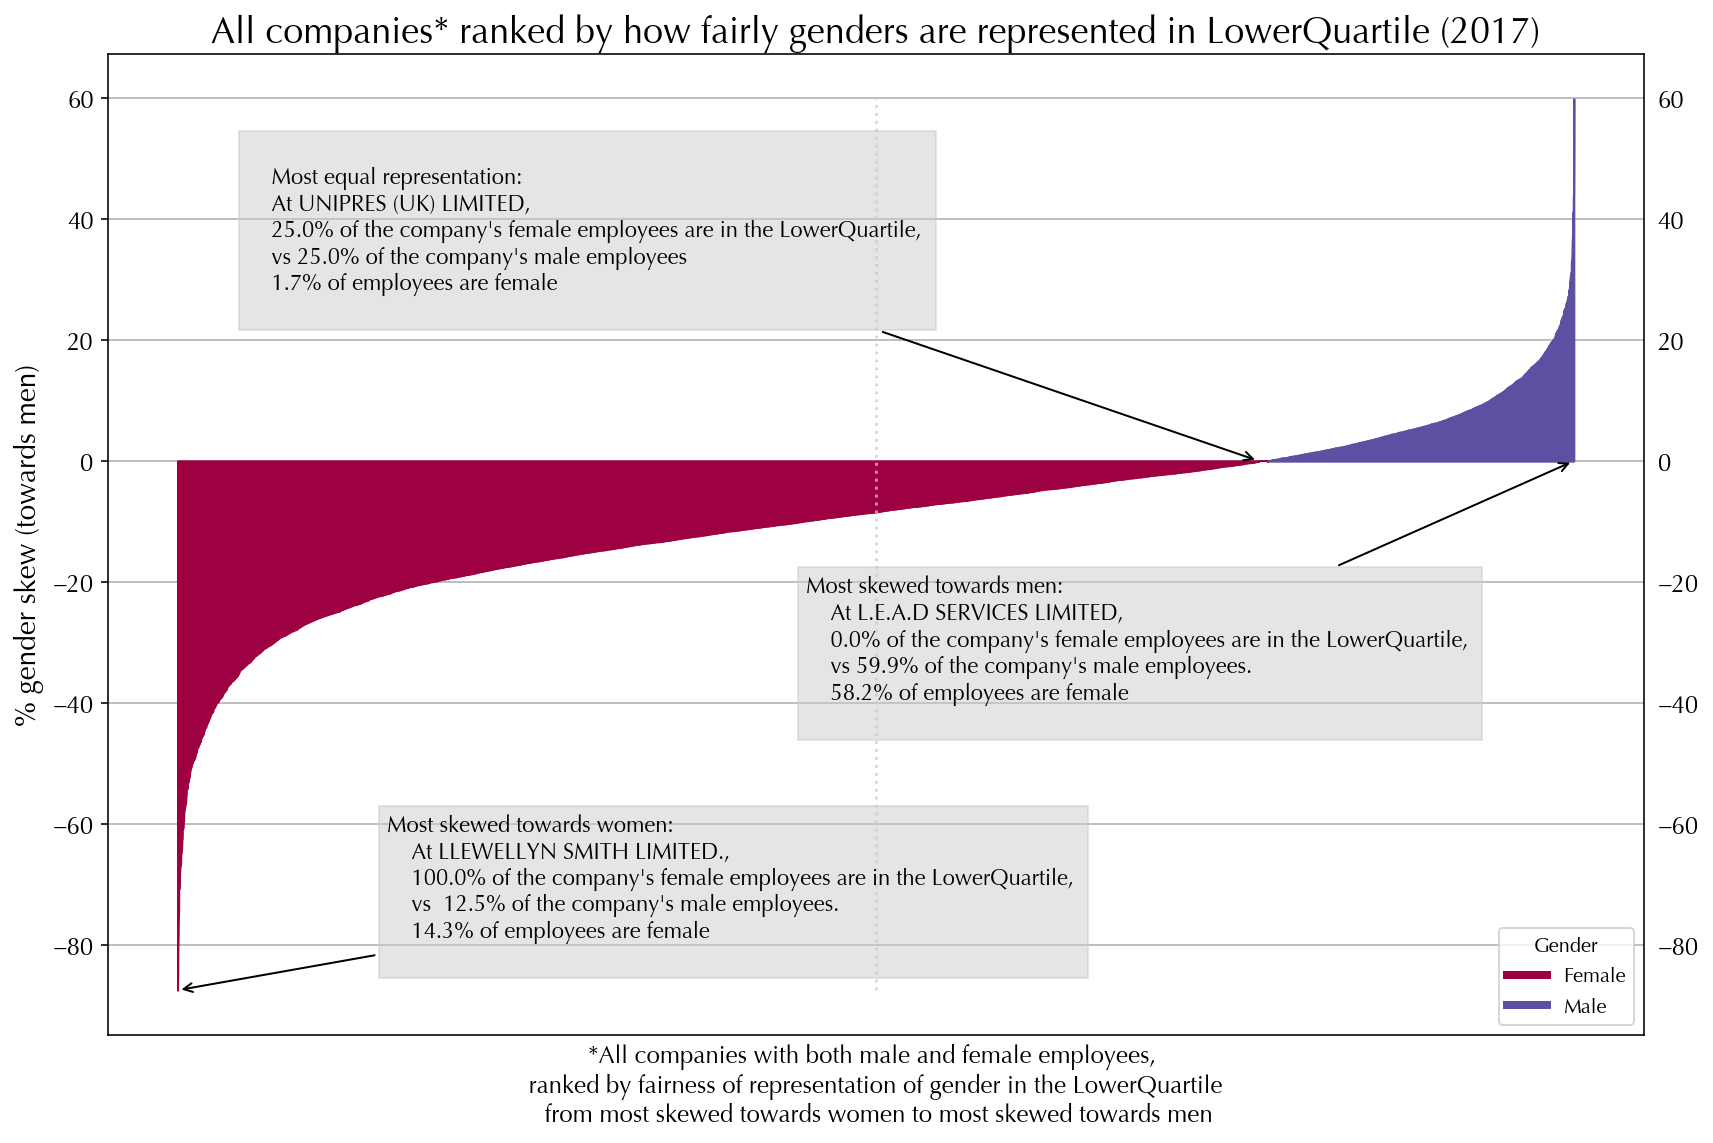

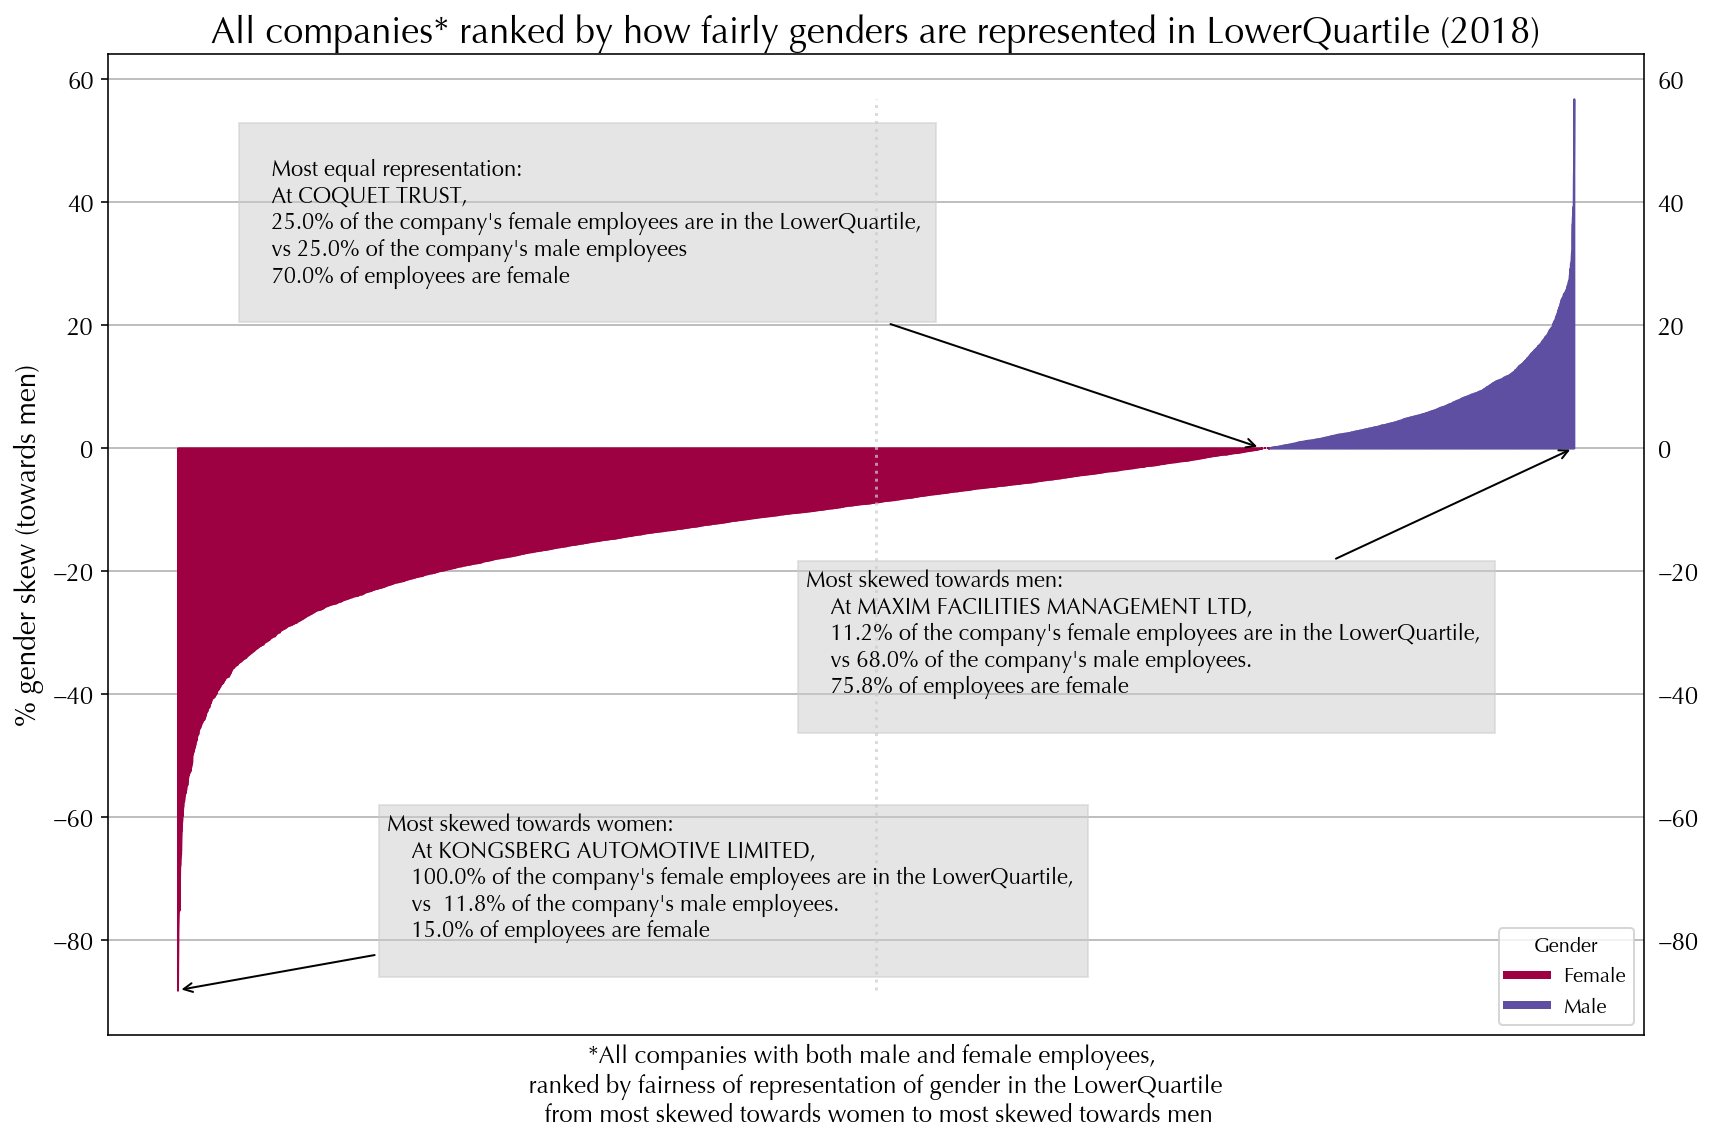

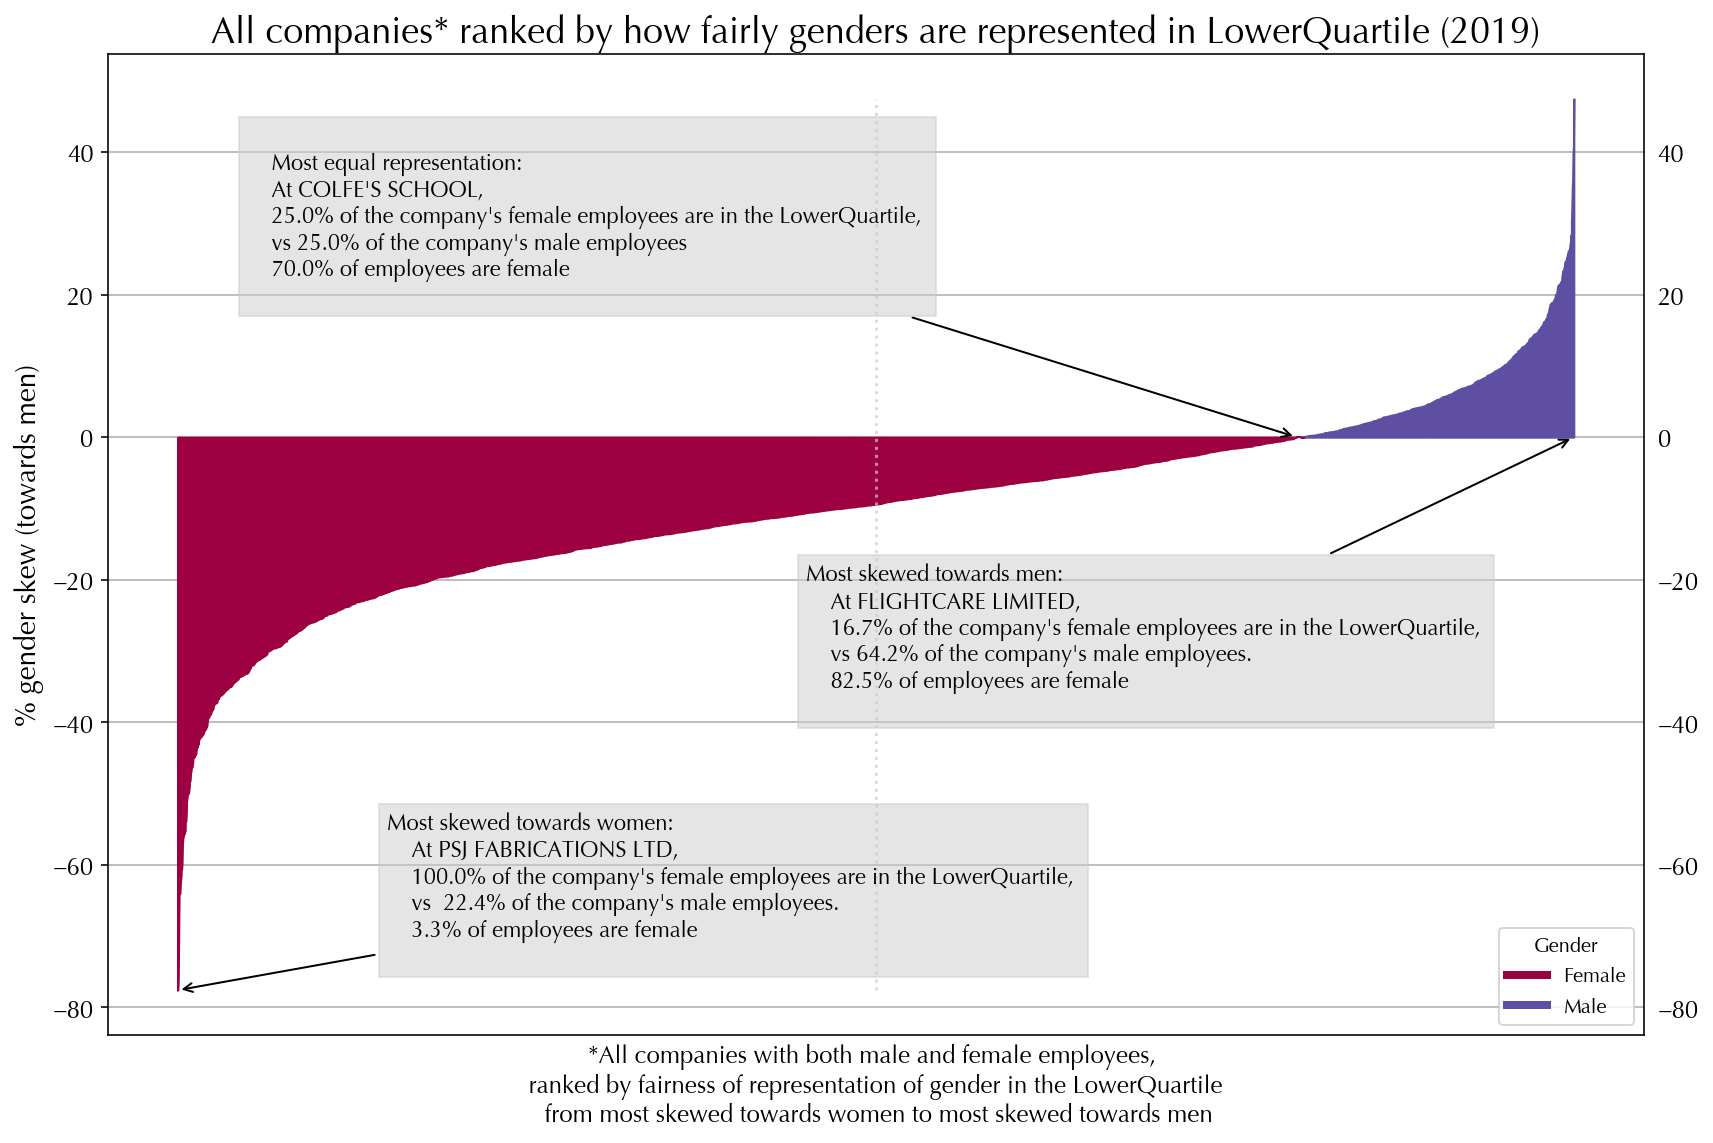

In [655]:
# Drop rows where the company is 100% male or 100% female
df_quartile = df[(df.MalePerc > 0.001) & (df.FemalePerc > 0.001)]

METRICS = ('TopQuartile', 'UpperMiddleQuartile', 'LowerMiddleQuartile', 'LowerQuartile')
for target_metric in METRICS:

    df_quartile['percOfAllMalesInQuartile'] = df_quartile['Male' + target_metric] / 4 /  df_quartile.MalePerc * 100
    df_quartile['percOfAllFemalesInQuartile'] = df_quartile['Female' + target_metric] / 4 / df_quartile.FemalePerc * 100
    df_quartile['metricDiff'] = df_quartile['percOfAllMalesInQuartile'] - df_quartile['percOfAllFemalesInQuartile']


    mpl.rcParams['font.family'] = 'Optima'
    mpl.rcParams['text.usetex'] = 'False'

    cmap = plt.cm.Spectral
    STEP_SIZE=10
    TRANSPARENT_GRAY=(0.8,0.8,0.8,0.7)
    metric = 'metricDiff'
    sort_by ='metricDiff'

    for year in YEARS:


        fig, ax = plt.subplots(1,1,figsize=(12,8))
        fig.patch.set_visible(False)
        y = df_quartile[df_quartile['year'] == year].sort_values(sort_by)[metric].values
        NUM_POINTS = len(y)
        x = np.arange(NUM_POINTS)
        normalize = colors.Normalize(vmin=min(y), vmax=max(y))

        tmp_df = df_quartile[df_quartile['year'] == year].sort_values(sort_by)
        fairest_idx = np.argmin(np.abs(tmp_df[metric].values))
        fairest_company = tmp_df['CurrentName'].values[fairest_idx]
        fairest_company_male_perc = tmp_df['percOfAllMalesInQuartile'].values[fairest_idx]
        fairest_company_female_perc = tmp_df['percOfAllFemalesInQuartile'].values[fairest_idx]
        fairest_company_total_female_perc = tmp_df['FemalePerc'].values[fairest_idx]

        min_index = df_quartile[df_quartile['year'] == year][metric].idxmin()
        most_women = df_quartile.loc[min_index,:]
        most_women_company = most_women['CurrentName']
        most_women_female_perc =  most_women['percOfAllFemalesInQuartile']
        most_women_male_perc =  most_women['percOfAllMalesInQuartile']
        most_women_total_female_perc = most_women['FemalePerc']

        max_index = df_quartile[df_quartile['year'] == year][metric].idxmax()
        most_men = df_quartile.loc[max_index,:]
        most_men_company = most_men['CurrentName']
        most_men_female_perc =  most_men['percOfAllFemalesInQuartile']
        most_men_male_perc =  most_men['percOfAllMalesInQuartile'] 
        most_men_total_female_perc = most_men['FemalePerc']


        # Draw bars for each of the companies
        for i in range(0, NUM_POINTS-1, STEP_SIZE):
            color = cmap(-1. if y[i] <0 else 1. if y[i] > 0 else 0)
            ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=color)

        ax.set_title('All companies* ranked by how fairly genders are represented in {} ({})'.format(target_metric, year),
                    **{ 'fontsize': 18})    

        ax.annotate(xytext=(.15 * NUM_POINTS, y[0] * .95),
                    s='''Most skewed towards women: 
    At {}, 
    {:.1f}% of the company\'s female employees are in the {}, 
    vs  {:.1f}% of the company\'s male employees. 
    {:.1f}% of employees are female
    '''
                        .format(most_women_company, most_women_female_perc, target_metric ,most_women_male_perc,
                               most_women_total_female_perc),
                    xy = (x[0], y[0]), 
                    arrowprops = dict(arrowstyle='->'),
                    **{'fontname':'Optima', 'fontsize': 11},
                    bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

        ax.annotate(xytext=(x[-1]-.55* NUM_POINTS , np.min(y)/2),
                    s='''Most skewed towards men: 
    At {}, 
    {:.1f}% of the company\'s female employees are in the {}, 
    vs {:.1f}% of the company\'s male employees.
    {:.1f}% of employees are female
    '''
                        .format(most_men_company, most_men_female_perc, target_metric ,most_men_male_perc,
                               most_men_total_female_perc),
                    xy = (x[-1], 0), 
                    arrowprops = dict(arrowstyle='->'),
                    **{'fontname':'Optima', 'fontsize': 11},
                    bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

        ax.annotate(xytext=(0.05 * NUM_POINTS, np.max(y)*0.4),
                    s='''
    Most equal representation: 
    At {}, 
    {}% of the company\'s female employees are in the {}, 
    vs {:.1f}% of the company\'s male employees
    {:.1f}% of employees are female
    '''
                        .format(fairest_company, fairest_company_male_perc, target_metric, fairest_company_female_perc,
                               fairest_company_total_female_perc),
                    xy = (x[fairest_idx], y[fairest_idx]), 
                    arrowprops = dict(arrowstyle='->'),
                    **{'fontname':'Optima', 'fontsize': 11},
                    bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))
        # A line down the middle as a visual indicator of where skew lies
        ax.plot([NUM_POINTS//2, NUM_POINTS//2], [np.min(y), np.max(y)], ls=':', color=TRANSPARENT_GRAY)

        ax.grid(axis='y')
        ax.set_axisbelow(True)
        ax.set_xlabel('*All companies with both male and female employees, \n ranked by fairness of representation of gender in the {} \n from most skewed towards women to most skewed towards men'.format(target_metric),
                     **{'fontsize': 12})
        ax.set_ylabel('% gender skew (towards men)', **{'fontsize': 14})

        plt.xticks([], [], fontsize=12)
        plt.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=12)
        plt.tight_layout()

        custom_legend = [Line2D([0], [0], color=cmap(0.), lw=4),
            Line2D([0], [0], color=cmap(1.), lw=4)]
        ax.legend(custom_legend, ['Female', 'Male'], title='Gender', loc='lower right')
        
        plt.savefig('Visualizations/{}-how-fair-genders-{}.png'.format(year, target_metric), dpi=150)

/Users/thor/.local/share/virtualenvs/data-exploration-2gHAQ7Cz/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


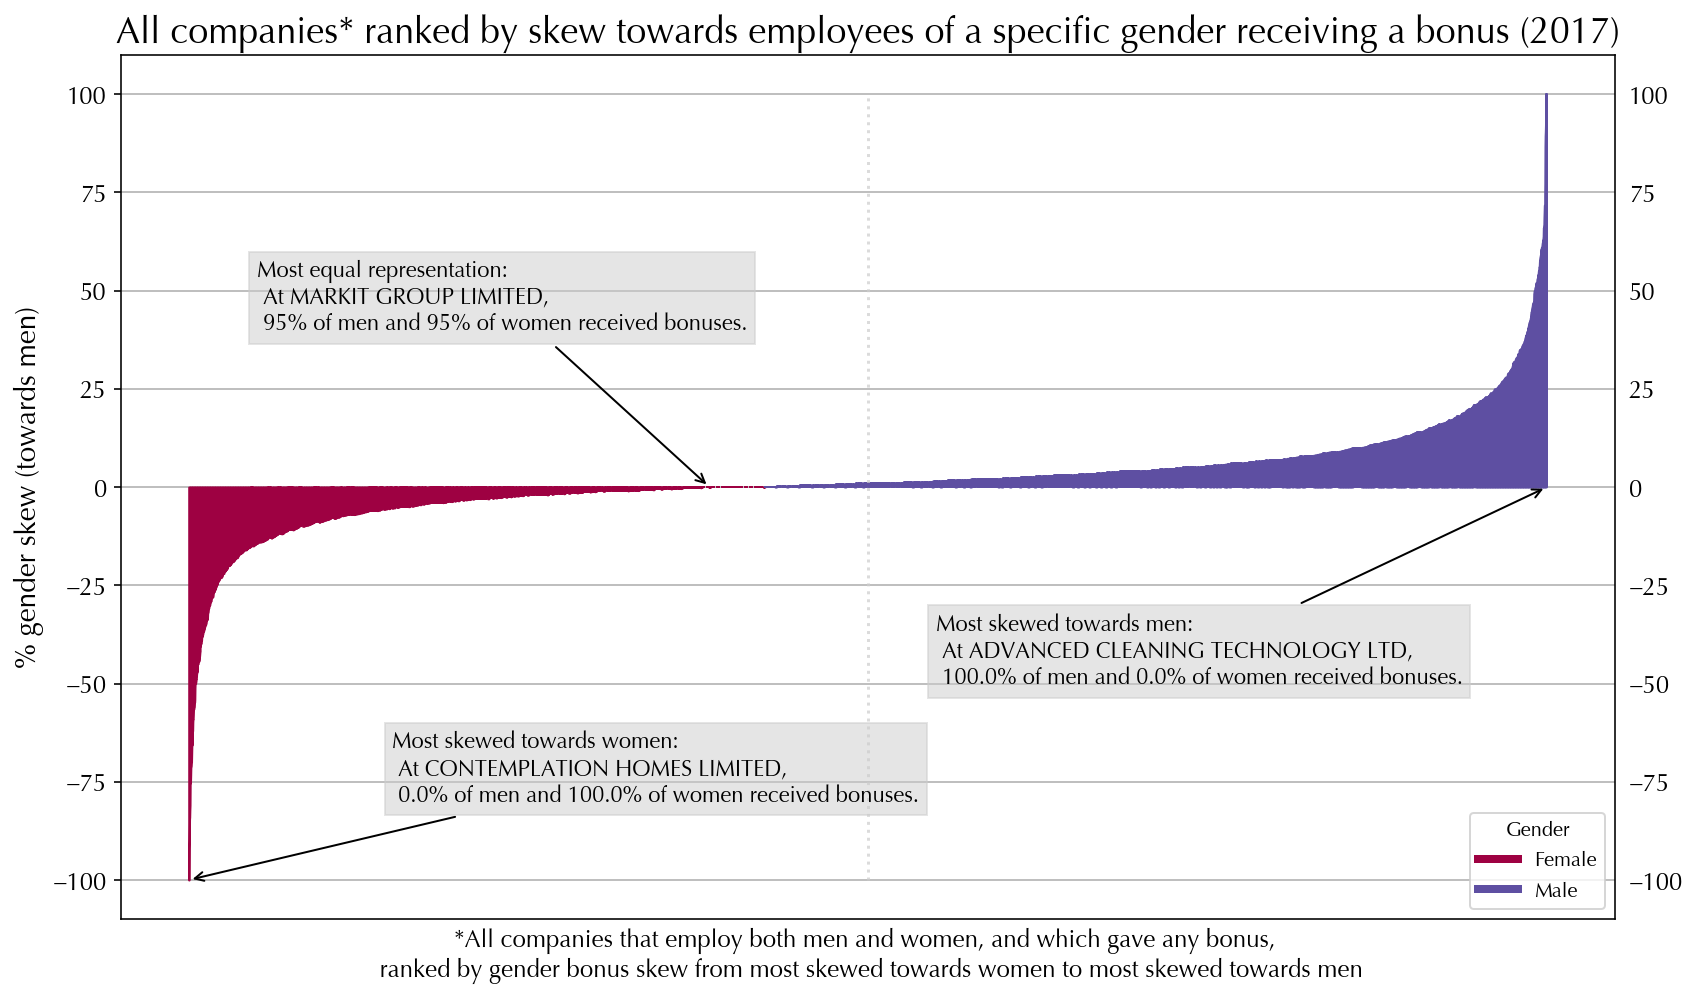

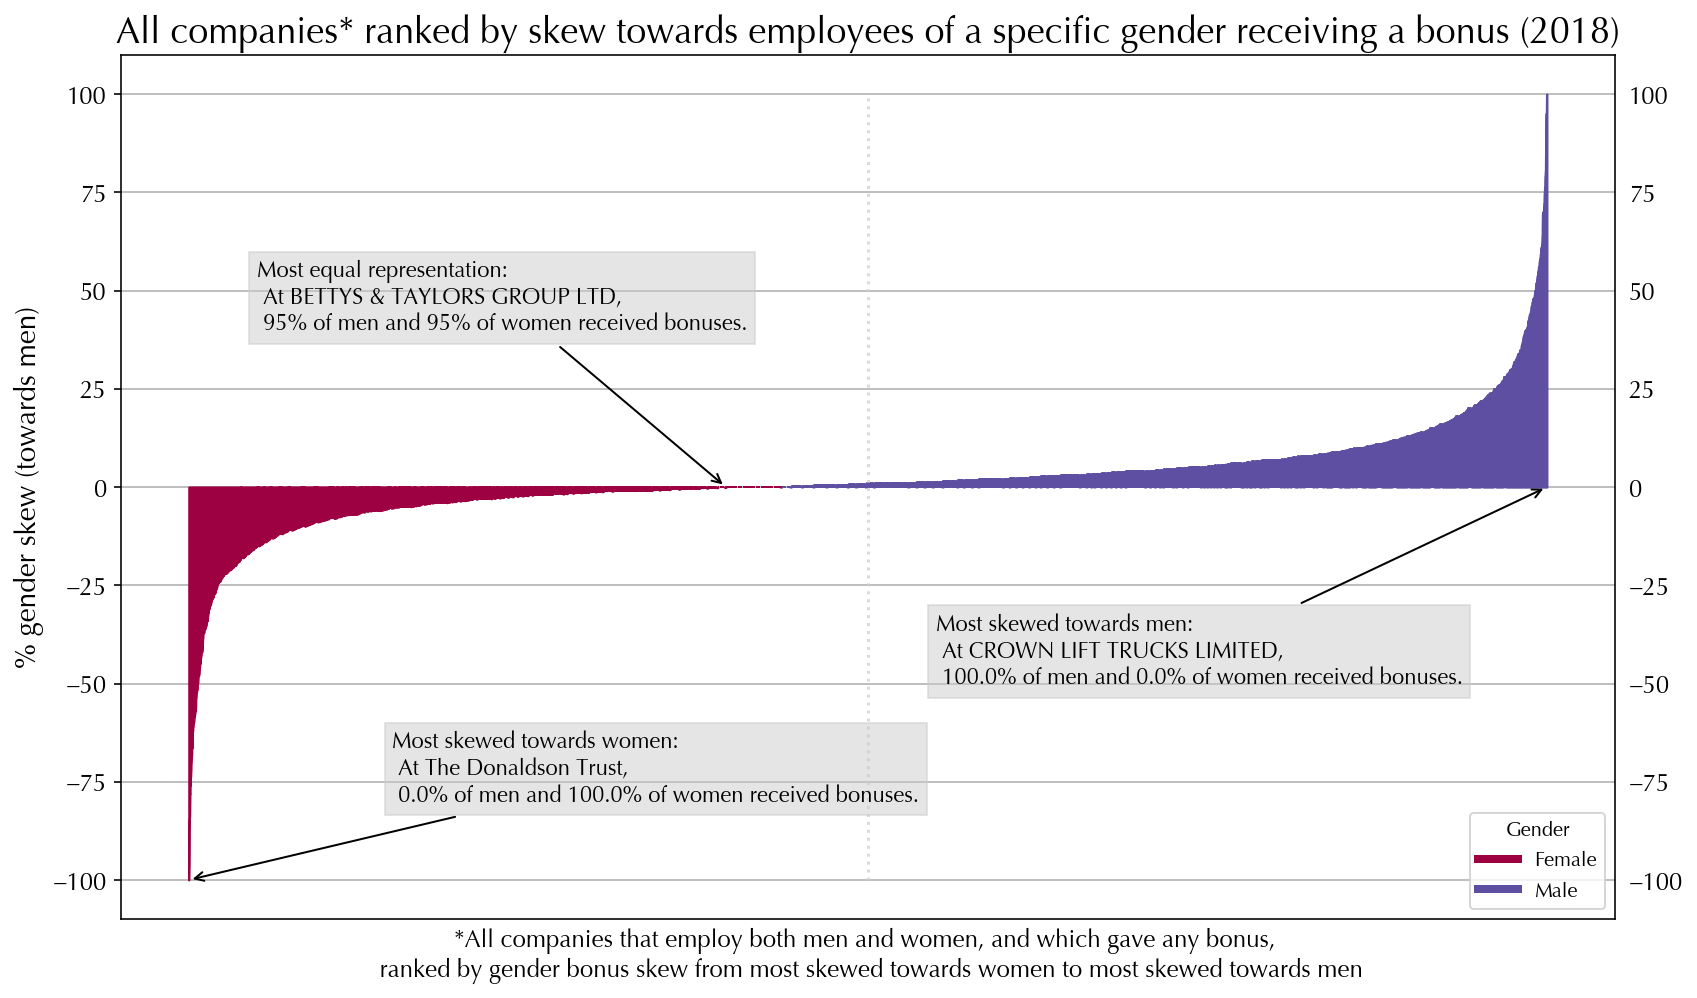

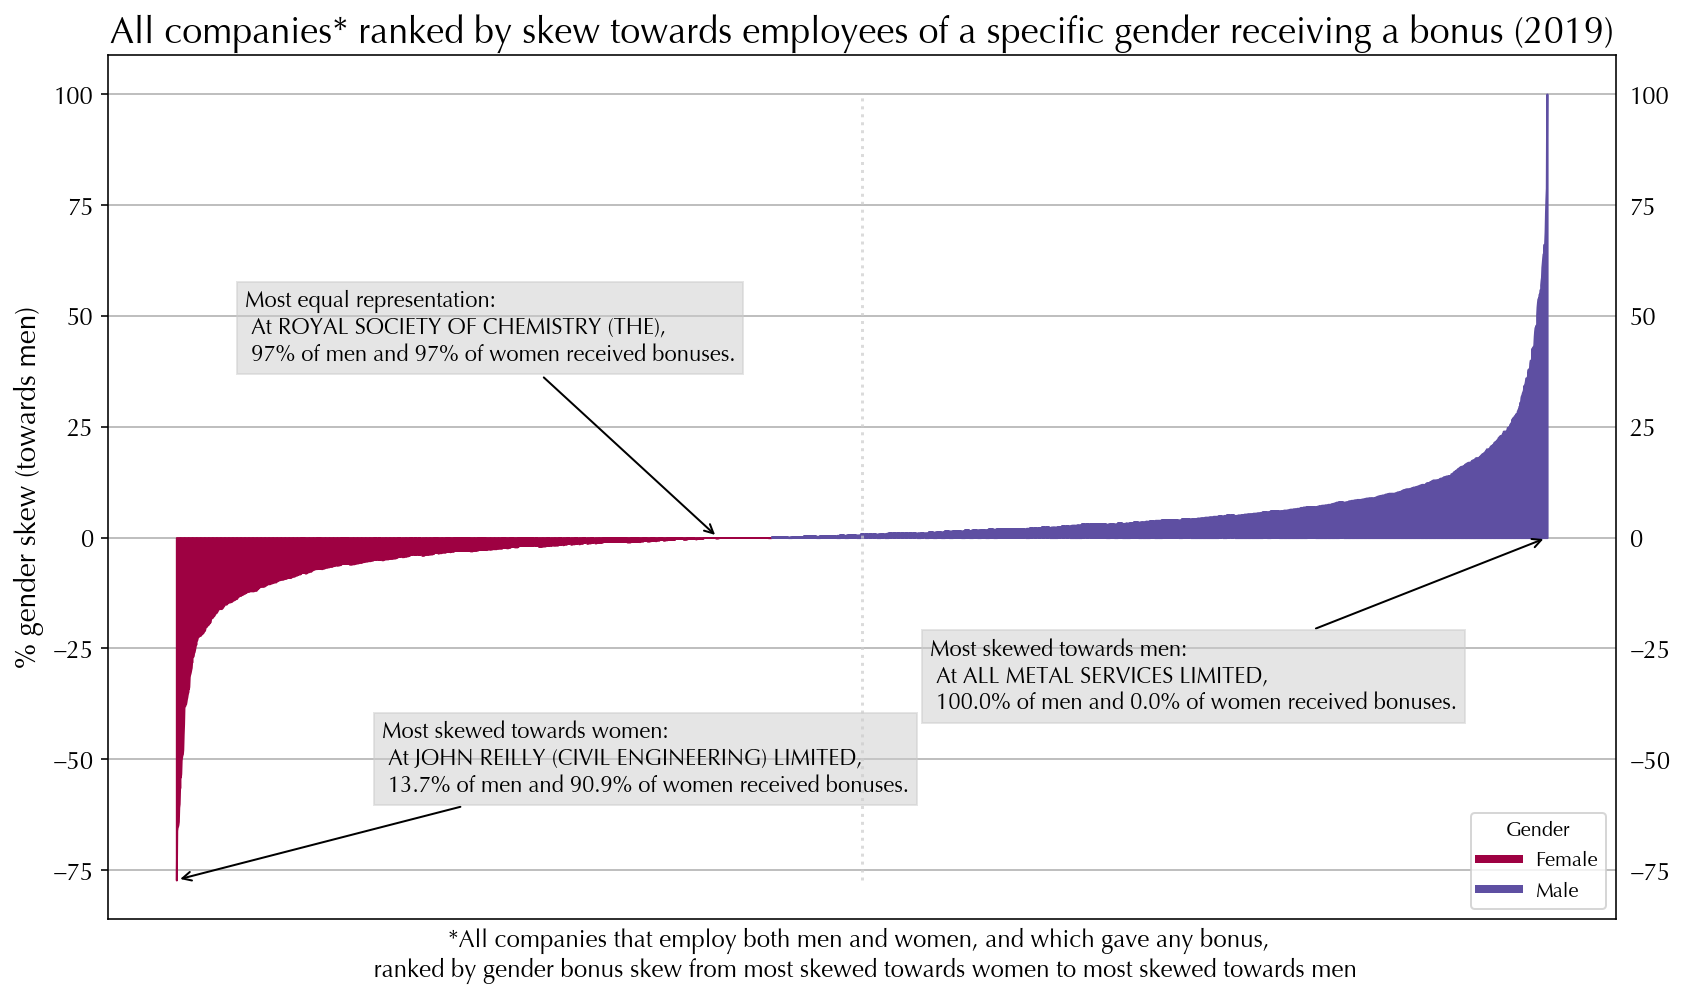

In [657]:
#We only want to show companies that have men and women, and where someone got a bonus
df_bonus = df[(df.MalePerc > 0.001) & (df.FemalePerc > 0.001)]
df_bonus = df_bonus[(df.MaleBonusPercent > 0.) | (df.FemaleBonusPercent > 0.)]


mpl.rcParams['font.family'] = 'Optima'
mpl.rcParams['text.usetex'] = 'False'

cmap = plt.cm.Spectral
STEP_SIZE=10
TRANSPARENT_GRAY=(0.8,0.8,0.8,0.7)
metric = 'BonusGenderSkew'
sort_by ='BonusGenderSkew'

for year in YEARS:
    fig, ax = plt.subplots(1,1,figsize=(12,7))
    fig.patch.set_visible(False)
    y = df_bonus[df_bonus['year'] == year].sort_values(sort_by)[metric].values
    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)
    normalize = colors.Normalize(vmin=min(y), vmax=max(y))

    tmp_df = df_bonus[df_bonus['year'] == year].sort_values(sort_by)
    fairest_idx = np.argmin(np.abs(tmp_df[metric].values))
    fairest_company = tmp_df['CurrentName'].values[fairest_idx]
    fairest_company_bonus_male = tmp_df['MaleBonusPercent'].values[fairest_idx]
    fairest_company_bonus_female = tmp_df['FemaleBonusPercent'].values[fairest_idx]
    
    min_index = df_bonus[df_bonus['year'] == year][metric].idxmin()
    most_women = df_bonus.loc[min_index,:]
    most_women_company = most_women['CurrentName']
    most_women_bonus_men =  most_women['MaleBonusPercent']
    most_women_bonus_women =  most_women['FemaleBonusPercent']
    
    max_index = df_bonus[df_bonus['year'] == year][metric].idxmax()
    most_men = df_bonus.loc[max_index,:]
    most_men_company = most_men['CurrentName']
    most_men_bonus_men =  most_men['MaleBonusPercent']
    most_men_bonus_women =  most_men['FemaleBonusPercent']

    # Draw bars for each of the companies
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        color = cmap(-1. if y[i] <0 else 1. if y[i] > 0 else 0)
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=color)

    ax.set_title('All companies* ranked by skew towards employees of a specific gender receiving a bonus ({})'.format(year),
                **{ 'fontsize': 18})    

    ax.annotate(xytext=(.15 * NUM_POINTS, y[0]+ 20),
                s='Most skewed towards women: \n At {}, \n {:.1f}% of men and {:.1f}% of women received bonuses.'
                    .format(most_women_company, most_women_bonus_men, most_women_bonus_women),
                xy = (x[0], y[0]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(x[-1]-.45 * NUM_POINTS , np.min(y)/2),
                s='Most skewed towards men: \n At {}, \n {:.1f}% of men and {:.1f}% of women received bonuses.'
                    .format(most_men_company, most_men_bonus_men, most_men_bonus_women),
                xy = (x[-1], 0), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(.05 * NUM_POINTS, 40),
                s='Most equal representation: \n At {}, \n {:.0f}% of men and {:.0f}% of women received bonuses.'
                    .format(fairest_company, fairest_company_bonus_male, fairest_company_bonus_female),
                xy = (x[fairest_idx], y[fairest_idx]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))
    # A line down the middle as a visual indicator of where skew lies
    ax.plot([NUM_POINTS//2, NUM_POINTS//2], [np.min(y), np.max(y)], ls=':', color=TRANSPARENT_GRAY)

    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xlabel('*All companies that employ both men and women, and which gave any bonus, \n ranked by gender bonus skew from most skewed towards women to most skewed towards men'.format(metric),
                 **{'fontsize': 12})
    ax.set_ylabel('% gender skew (towards men)', **{'fontsize': 14})

    custom_legend = [Line2D([0], [0], color=cmap(0.), lw=4),
            Line2D([0], [0], color=cmap(1.), lw=4)]
    ax.legend(custom_legend, ['Female', 'Male'], title='Gender', loc='lower right')
    
    plt.xticks([], [], fontsize=12)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=12)
    plt.tight_layout()
    plt.savefig('Visualizations/{}-all-companies-bonus-skew.png'.format(year), dpi=150)

/Users/thor/.local/share/virtualenvs/data-exploration-2gHAQ7Cz/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


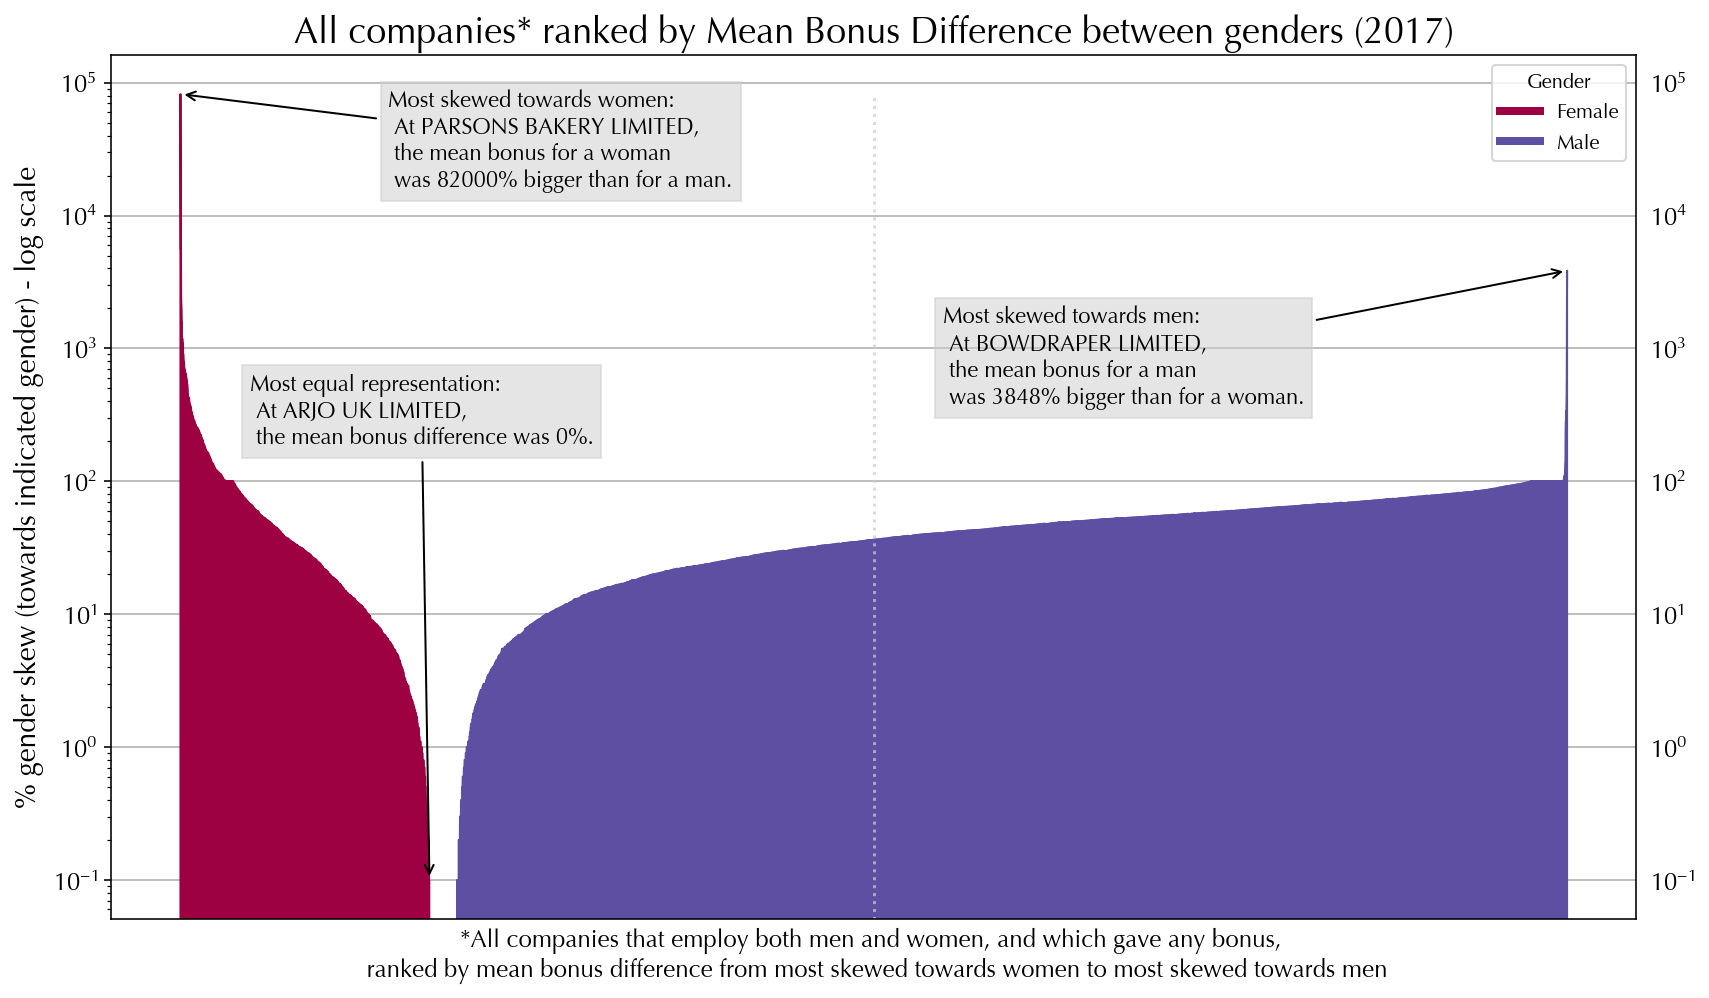

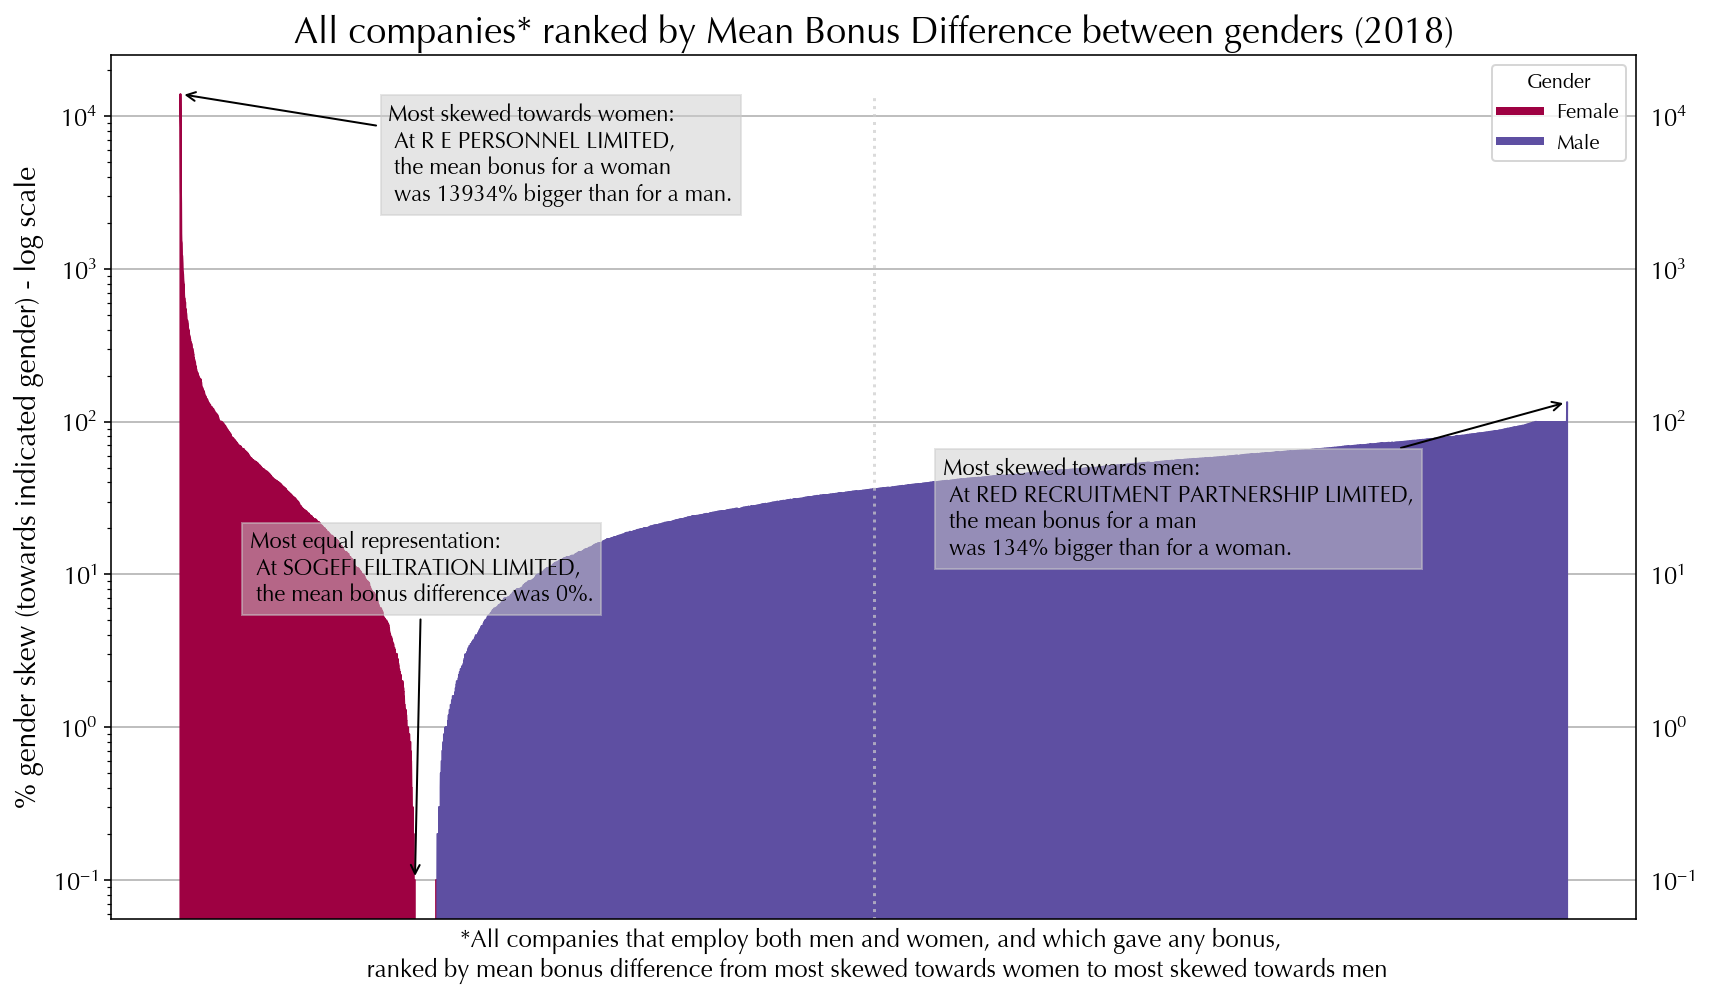

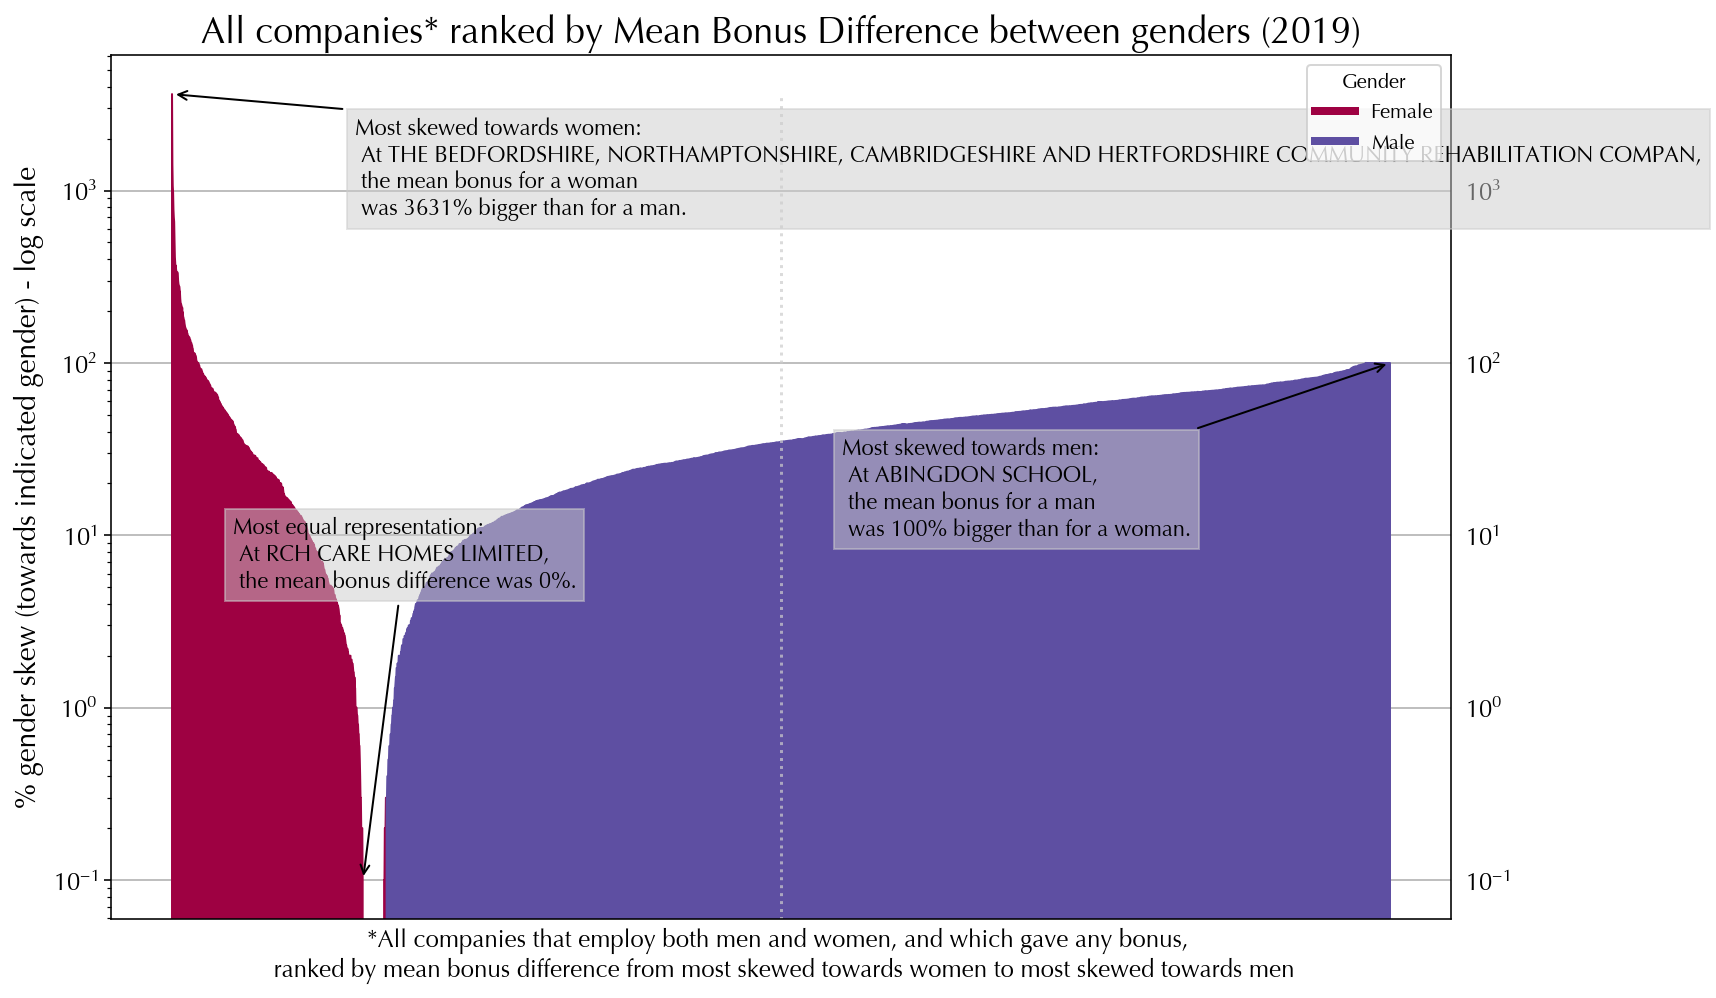

In [641]:
#We only want to show companies that have men and women, and where someone got a bonus
df_bonus = df[(df.MalePerc > 0.001) & (df.FemalePerc > 0.001)]
df_bonus = df_bonus[(df.MaleBonusPercent > 0.) | (df.FemaleBonusPercent > 0.)]

mpl.rcParams['font.family'] = 'Optima'
mpl.rcParams['text.usetex'] = 'False'

cmap = plt.cm.Spectral
STEP_SIZE=10
TRANSPARENT_GRAY=(0.8,0.8,0.8,0.7)
metric = 'DiffMeanBonusPercent'
sort_by ='DiffMeanBonusPercent'

for year in YEARS:
    fig, ax = plt.subplots(1,1,figsize=(12,7))
    fig.patch.set_visible(False)
    orig_y = df_bonus[df_bonus['year'] == year].sort_values(sort_by)[metric].values
    y = np.abs(orig_y)

    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)
    normalize = colors.Normalize(vmin=min(y), vmax=max(y))

    tmp_df = df_bonus[df_bonus['year'] == year].sort_values(sort_by)
    fairest_idx = np.argmin(np.abs(tmp_df[metric].values))
    fairest_company = tmp_df['CurrentName'].values[fairest_idx]
    fairest_company_bonus = np.abs(tmp_df['DiffMeanBonusPercent'].values[fairest_idx])
    
    min_index = df_bonus[df_bonus['year'] == year][metric].idxmin()
    most_women = df_bonus.loc[min_index,:]
    most_women_company = most_women['CurrentName']
    most_women_bonus =  -most_women['DiffMeanBonusPercent']
    
    max_index = df_bonus[df_bonus['year'] == year][metric].idxmax()
    most_men = df_bonus.loc[max_index,:]
    most_men_company = most_men['CurrentName']
    most_men_bonus =  most_men['DiffMeanBonusPercent']
    ax.set_yscale('log')

    # Draw bars for each of the companies
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        color = cmap(-1. if orig_y[i] <0 else 1. if orig_y[i] > 0 else 0)
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=color)

    ax.set_title('All companies* ranked by Mean Bonus Difference between genders ({})'.format(year),
                **{ 'fontsize': 18})    

    ax.annotate(xytext=(.15 * NUM_POINTS, y[0]*.2),
                s='Most skewed towards women: \n At {},\n the mean bonus for a woman \n was {:.0f}% bigger than for a man.'
                    .format(most_women_company, most_women_bonus),
                xy = (x[0], y[0]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(x[-1]-.45 * NUM_POINTS , y[-1]*.1),
                s='Most skewed towards men: \n At {},\n the mean bonus for a man \n was {:.0f}% bigger than for a woman.'
                    .format(most_men_company, most_men_bonus),
                xy = (x[-1], y[-1]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(.05 * NUM_POINTS, y[-1]*.05),
                s='Most equal representation: \n At {},\n the mean bonus difference was {:.0f}%.'
                    .format(fairest_company, fairest_company_bonus),
                xy = (x[fairest_idx], 1e-1), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))
    # A line down the middle as a visual indicator of where skew lies
    ax.plot([NUM_POINTS//2, NUM_POINTS//2], [np.min(y), np.max(y)], ls=':', color=TRANSPARENT_GRAY)

    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xlabel('*All companies that employ both men and women, and which gave any bonus, \n ranked by mean bonus difference from most skewed towards women to most skewed towards men'.format(metric),
                 **{'fontsize': 12})
    ax.set_ylabel('% gender skew (towards indicated gender) - log scale', **{'fontsize': 14})
    plt.xticks([], [], fontsize=12)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=12)
    plt.tight_layout()
    custom_legend = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

    ax.legend(custom_legend, ['Female', 'Male'], title='Gender')

    plt.savefig('Visualizations/{}-all-companies-bonus-diffmean.png'.format(year), dpi=150)

/Users/thor/.local/share/virtualenvs/data-exploration-2gHAQ7Cz/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


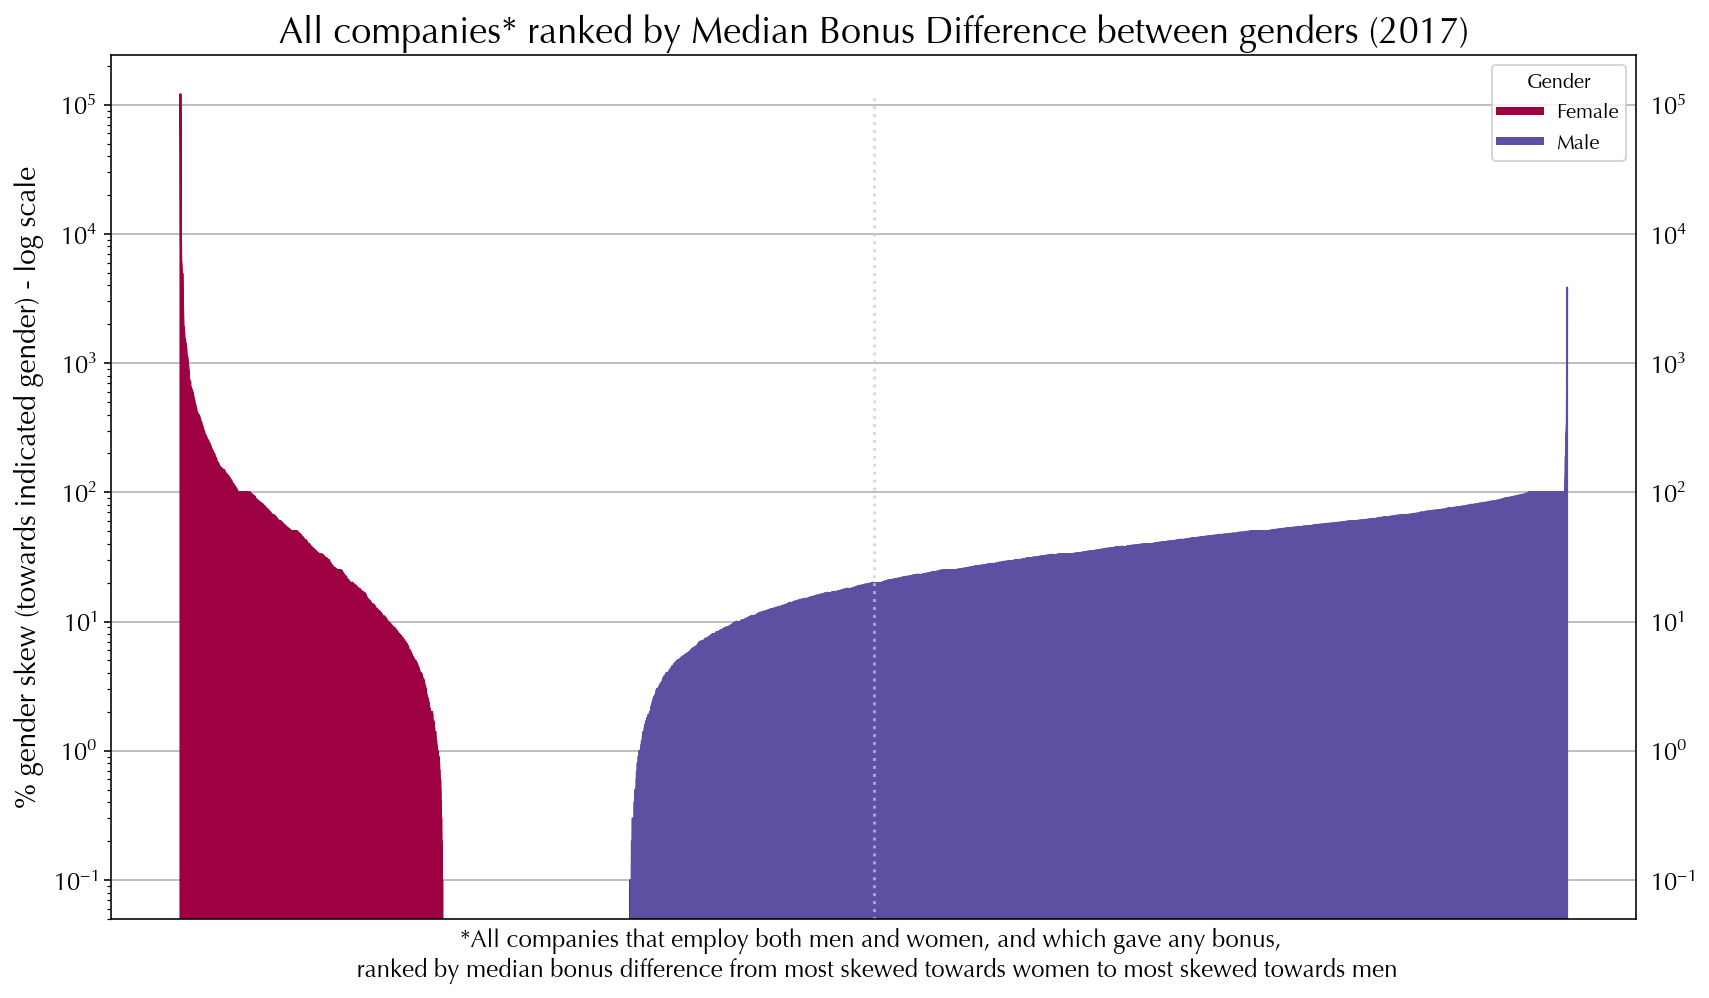

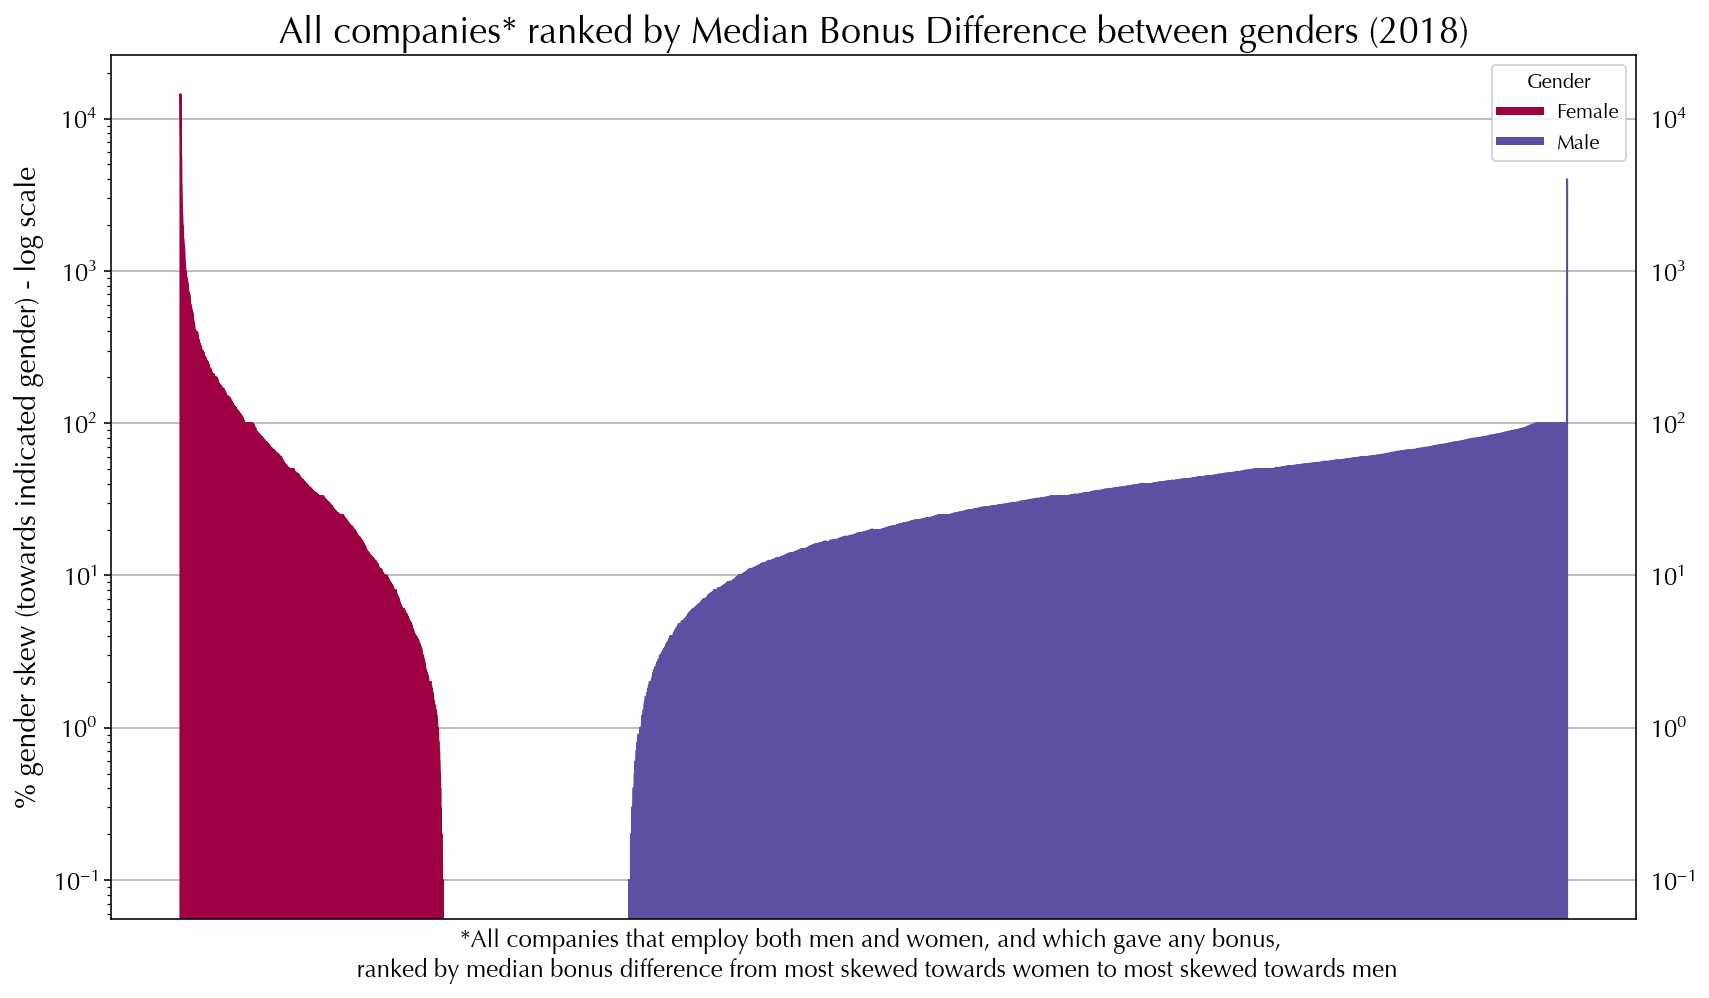

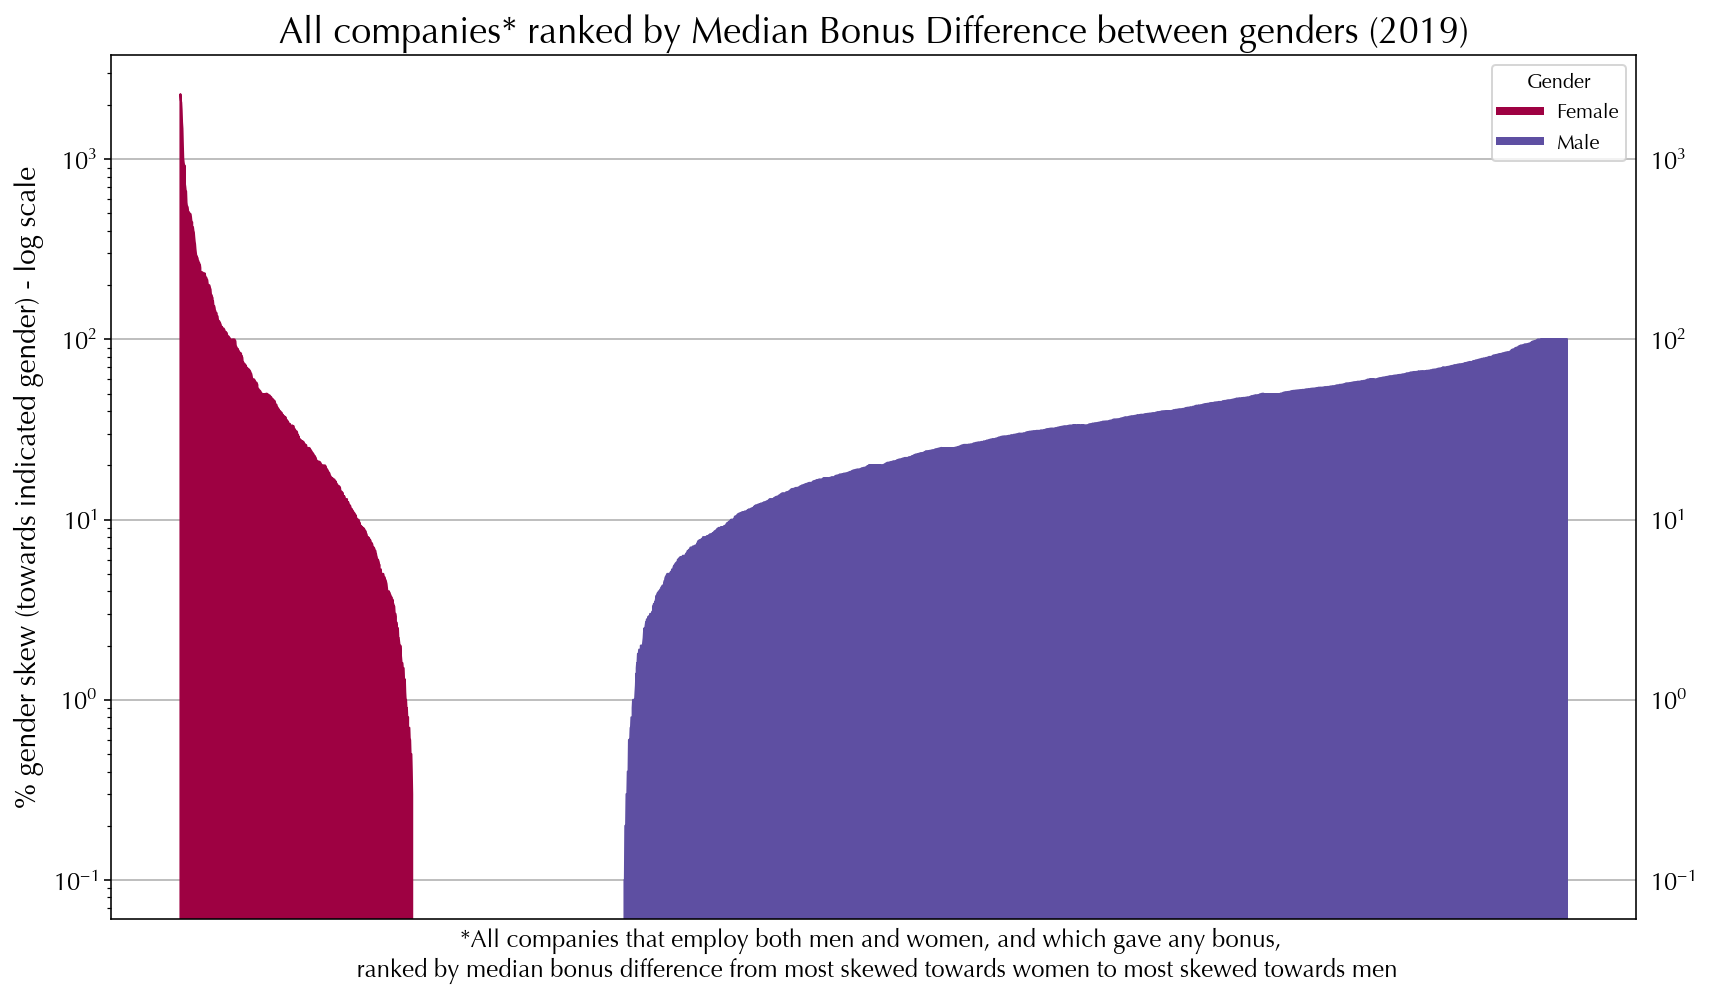

In [643]:
#We only want to show companies that have men and women, and where someone got a bonus
df_bonus = df[(df.MalePerc > 0.001) & (df.FemalePerc > 0.001)]
df_bonus = df_bonus[(df.MaleBonusPercent > 0.) | (df.FemaleBonusPercent > 0.)]

mpl.rcParams['font.family'] = 'Optima'
mpl.rcParams['text.usetex'] = 'False'

cmap = plt.cm.Spectral
STEP_SIZE=10
TRANSPARENT_GRAY=(0.8,0.8,0.8,0.7)
metric = 'DiffMedianBonusPercent'
sort_by ='DiffMedianBonusPercent'

for year in YEARS:
    fig, ax = plt.subplots(1,1,figsize=(12,7))
    fig.patch.set_visible(False)
    orig_y = df_bonus[df_bonus['year'] == year].sort_values(sort_by)[metric].values
    y = np.abs(orig_y)

    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)
    normalize = colors.Normalize(vmin=min(y), vmax=max(y))

    tmp_df = df_bonus[df_bonus['year'] == year].sort_values(sort_by)
    fairest_idx = np.argmin(np.abs(tmp_df[metric].values))
    fairest_company = tmp_df['CurrentName'].values[fairest_idx]
    fairest_company_bonus = np.abs(tmp_df['DiffMedianBonusPercent'].values[fairest_idx])
    
    min_index = df_bonus[df_bonus['year'] == year][metric].idxmin()
    most_women = df_bonus.loc[min_index,:]
    most_women_company = most_women['CurrentName']
    most_women_bonus =  -most_women['DiffMedianBonusPercent']
    
    max_index = df_bonus[df_bonus['year'] == year][metric].idxmax()
    most_men = df_bonus.loc[max_index,:]
    most_men_company = most_men['CurrentName']
    most_men_bonus =  most_men['DiffMedianBonusPercent']
    ax.set_yscale('log')

    # Draw bars for each of the companies
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        color = cmap(-1. if orig_y[i] <0 else 1. if orig_y[i] > 0 else 0)
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=color)

    ax.set_title('All companies* ranked by Median Bonus Difference between genders ({})'.format(year),
                **{ 'fontsize': 18})    

    ax.annotate(xytext=(.15 * NUM_POINTS, y[0]*.2),
                s='Most skewed towards women: \n At {},\n the median bonus for a woman \n was {:.0f}% bigger than for a man.'
                    .format(most_women_company, most_women_bonus),
                xy = (x[0], y[0]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(x[-1]-.45 * NUM_POINTS , y[-1]*.1),
                s='Most skewed towards men: \n At {},\n the median bonus for a man \n was {:.0f}% bigger than for a woman.'
                    .format(most_men_company, most_men_bonus),
                xy = (x[-1], y[-1]), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))

    ax.annotate(xytext=(.05 * NUM_POINTS, y[-1]*.05),
                s='Most equal representation: \n At {},\n the median bonus difference was {:.0f}%.'
                    .format(fairest_company, fairest_company_bonus),
                xy = (x[fairest_idx], 1e-1), 
                arrowprops = dict(arrowstyle='->'),
                **{'fontname':'Optima', 'fontsize': 11},
                bbox= dict(facecolor=TRANSPARENT_GRAY, alpha=0.5, edgecolor=TRANSPARENT_GRAY))
    # A line down the middle as a visual indicator of where skew lies
    ax.plot([NUM_POINTS//2, NUM_POINTS//2], [np.min(y), np.max(y)], ls=':', color=TRANSPARENT_GRAY)

    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xlabel('*All companies that employ both men and women, and which gave any bonus, \n ranked by median bonus difference from most skewed towards women to most skewed towards men'.format(metric),
                 **{'fontsize': 12})
    ax.set_ylabel('% gender skew (towards indicated gender) - log scale', **{'fontsize': 14})
    plt.xticks([], [], fontsize=12)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=12)
    plt.tight_layout()
    custom_legend = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

    ax.legend(custom_legend, ['Female', 'Male'], title='Gender')

    plt.savefig('Visualizations/{}-all-companies-bonus-diffmedian.png'.format(year), dpi=150)